In [1]:
import os, random, numpy as np
import pandas as pd
from pathlib import Path
import shutil
from questionnaire_functions import (export_questionnaire,build_timepoint_presence_matrix,analyze_questionnaire)
from pca_functions import (find_optimal_pca_dimensions,plot_pca_weights_two_cols_split,plot_pca_weights_separate_and_table)
from clustring_functions import(pca_kmeans_minimal_outputs,run_kmeans_clustering,invert_binary_columns,gap_statistic)
from vizualizations_functions import (plot_grouped_bars,plot_multi_dataset_scatters_colored,plot_one_period_with_labels,get_labels_from_file,plot_one_period_with_labels_and_ttest,
plot_subject_trajectories,stats_by_group,safe)
from preprocessing_functions import (load_one,transition_for_pair)
from functools import reduce
import textwrap
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import ttest_rel



# file creation

## creating a file of the clusters and the totals after the pregnancy

In [2]:
import pandas as pd

# -----------------------------
# 1. Load the Excel file
# -----------------------------
excel_path = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
df = pd.read_excel(excel_path)
print(df.columns.tolist())
# -----------------------------
# 2. Load the list of allowed Subject_Code
# -----------------------------
allowed_path = r"only_Q_outputs\combined\clusters_combined.csv"
allowed_df = pd.read_csv(allowed_path)

id_col = "Subject_Code"

# Extract allowed subject IDs
allowed_ids = allowed_df[id_col].dropna().unique()

# -----------------------------
# 3. Filter the main Excel file by allowed subjects
# -----------------------------
filtered = df[df[id_col].isin(allowed_ids)].copy()

# -----------------------------
# 4. Choose which columns from Excel to keep
#    Put your desired column names here
# -----------------------------

selected_columns = [
    "Subject_Code",
 'after_bits_PTSD_total', 'after_bits_birth_symptoms', 'after_bits_General_symptoms', 'after_bits_Dissociatie_symptoms', 
 'after_bits_PTSD_criterion', 'after_bits_Re_experiencing ',
 'after_bits_Avoidance ', 'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal', 'after_MPAS_total', 'after_MPAS_Attachment', 
 'after_MPAS_Hostility', 'after_MPAS_Interaction', 'after_DES_total', 'after_DES_Absorption ', 'after_DES_Amnesia', 
 'after_DES_Depersonalization', 'after_CTQ_total', 'after_CTQ_cutoff', 'after_CTQ_NEGLECT', 'after_CTQ_ABUSE  ',
 'after_CTQ_sexual_abuse', 'after_CTQ_physical_abuse', 'after_CTQ_emotional_abuse', 'after_CTQ_physical_neglect',
 'after_CTQ_emotional_neglect', 'after_CTQ_sexual_abuse_cutoff', 'after_CTQ_physical_abuse_cutoff', 'after_CTQ_emotional_abuse_cutoff',
 'after_CTQ_physical_neglect_cutoff', 'after_CTQ_emotional_neglect_cutoff', 'after_CTQ_denial _score', 'after_DERS_total', 'after_DERS_Nonacceptance_Emotional_Responses',
 'after_DERS_Goal_Directed_Behavior', 'after_DERS_Impulse_Control', 
 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity',  'after_LHQ_total']


# Keep only the selected columns (if they exist)
available_selected = [c for c in selected_columns if c in filtered.columns]
missing_columns = [c for c in selected_columns if c not in filtered.columns]

if missing_columns:
    print("Warning: These selected columns do not exist in the Excel file:", missing_columns)

filtered = filtered[available_selected]

# -----------------------------
# 5. Save the result to CSV
# -----------------------------
output_path = r"only_Q_outputs/combined/total_clinical_parameters.csv"
filtered.to_csv(output_path, index=False)

print("Saved filtered CSV to:", output_path)


['study_id', 'Subject_Code', 'diamond_interview_date', 'b_diamond_anxiety_phobias_past', 'b_diamond_Anxiety_phobias_present', 'b_diamond_ocd_past', 'b_diamond_ocd_present', 'b_diamond_adhd_past', 'b_diamond_adhd_present', 'b_diamond_depression_past', 'b_diamond_depression_present', 'b_diamond_adjustment_past', 'b_diamond_adjustment_present', 'b_diamond_ptsd_past', 'b_diamond_ptsd_present', 'b_diamond_eating_disorder_past', 'b_diamond_eating_disorder_present', 'b_diamond_PMS_past', 'b_diamond_PMS_present', 'b_diamond_other_past', 'b_diamond_other_present', 'b_diamond_past', 'b_diamond_present', 'Dropped_Out_of_Study', 'Became_Pregnant', 'Gave_Birth', 'Dominant_hand', 'Completed_First_fMRI', 'Completed_Second_fMRI', 'Completed_Third_fMRI', 'b_questionnaire_completion', 'after_questionnaire_completion', 'first_fmri_scan_date', 'second_fmri_scan_date', 'third_fmri_scan_date', 'b_questionnaire_and_fmri_days_difference', 'pregnancy_start_date', 'b_questionnaire_and_pregnancy_days_difference'

## creatign a file of the clinical parameters of the totals in the trimesters and  after

In [3]:
import pandas as pd

# --- CONFIGURATION ---
input_file = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"

# Columns you want in the new fil'
columns_to_keep = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DERS_total',
    'after_DES_total']
# <-- Replace ColumnA, ColumnB, ColumnC with the real column names you want.


# --- LOAD EXCEL FILE ---
df = pd.read_excel(input_file)
print(df.columns.to_list())
# --- CHECK IF COLUMNS EXIST ---
missing = [col for col in columns_to_keep if col not in df.columns]
if missing:
    print("❌ These columns do NOT exist in the file:", missing)
else:
    # --- SELECT COLUMNS ---
    new_df = df[columns_to_keep]

    # --- SAVE TO CSV ---
    new_df.to_csv("only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv", index=False)
    print("✅ File created: regression_parameters.csv")


['study_id', 'Subject_Code', 'diamond_interview_date', 'b_diamond_anxiety_phobias_past', 'b_diamond_Anxiety_phobias_present', 'b_diamond_ocd_past', 'b_diamond_ocd_present', 'b_diamond_adhd_past', 'b_diamond_adhd_present', 'b_diamond_depression_past', 'b_diamond_depression_present', 'b_diamond_adjustment_past', 'b_diamond_adjustment_present', 'b_diamond_ptsd_past', 'b_diamond_ptsd_present', 'b_diamond_eating_disorder_past', 'b_diamond_eating_disorder_present', 'b_diamond_PMS_past', 'b_diamond_PMS_present', 'b_diamond_other_past', 'b_diamond_other_present', 'b_diamond_past', 'b_diamond_present', 'Dropped_Out_of_Study', 'Became_Pregnant', 'Gave_Birth', 'Dominant_hand', 'Completed_First_fMRI', 'Completed_Second_fMRI', 'Completed_Third_fMRI', 'b_questionnaire_completion', 'after_questionnaire_completion', 'first_fmri_scan_date', 'second_fmri_scan_date', 'third_fmri_scan_date', 'b_questionnaire_and_fmri_days_difference', 'pregnancy_start_date', 'b_questionnaire_and_pregnancy_days_difference'

## creatign files for each tiem sepratley with the clustering and the clinimcal parameters 

In [4]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

timepoints_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"

time_df = pd.read_csv(timepoints_path)
reg_df = pd.read_csv(regression_path)

# -------------------------
# 2. Choose columns from regression_parameters
#    Make sure "Subject_Code" is included
# -------------------------

# regression_cols = [
#     "Subject_Code"
#    ,'b_DERS_total','b_DES_average','after_DES_total','after_DERS_total'
# ]
regression_cols =  ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total']
reg_sel = reg_df[regression_cols].copy()

# helper: list of regression columns WITHOUT Subject_Code
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Filter subjects that have value in column 'b' / 'after'
#    Here "have value" = not NaN. If in your file it's 0/1, you can change to != 0.
# -------------------------

# subjects with value in column 'b'
b_subjects = time_df[time_df["b"].notna()].copy()
# e.g. if it's 0/1 then:
# b_subjects = time_df[time_df["b"] != 0].copy()

# subjects with value in column 'after'
after_subjects = time_df[time_df["after"].notna()].copy()
# or if it's 0/1:
# after_subjects = time_df[time_df["after"] != 0].copy()
t1_subjects = time_df[time_df["t1"].notna()].copy()
t2_subjects = time_df[time_df["t2"].notna()].copy()
t3_subjects = time_df[time_df["t3"].notna()].copy()

# ------------------
# 4. Merge with regression parameters on Subject_Code
# -------------------------

b_merged_full = pd.merge(
    b_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)
t1_merged_full = pd.merge(
    t1_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)
t2_merged_full = pd.merge(
    t2_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)
t3_merged_full = pd.merge(
    t3_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

after_merged_full = pd.merge(
    after_subjects,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Keep ONLY:
#    Subject_Code + wanted timepoint column + regression parameters
# -------------------------

b_final = b_merged_full[["Subject_Code", "b"] + reg_param_cols].copy()
after_final = after_merged_full[["Subject_Code", "after"] + reg_param_cols].copy()
after_t1 = after_merged_full[["Subject_Code", "t1"] + reg_param_cols].copy()
after_t2 = after_merged_full[["Subject_Code", "t2"] + reg_param_cols].copy()
after_t3 = after_merged_full[["Subject_Code", "t3"] + reg_param_cols].copy()

# -------------------------
# 6. Save the two final files
# -------------------------
b_final = b_final.rename(columns={"b": "cluster"})
after_final = after_final.rename(columns={"after": "cluster"})
t1_final = after_final.rename(columns={"t1": "cluster"})
t2_final = after_final.rename(columns={"t2": "cluster"})
t3_final = after_final.rename(columns={"t3": "cluster"})

b_output_path = r"only_Q_outputs/combined/regression/subjects_b_with_regression_clean.csv"
after_output_path = r"only_Q_outputs/combined/regression/subjects_after_with_regression_clean.csv"
t1_output_path = r"only_Q_outputs/combined/regression/subjects_t1_with_regression_clean.csv"
t2_output_path = r"only_Q_outputs/combined/regression/subjects_t2_with_regression_clean.csv"
t3_output_path = r"only_Q_outputs/combined/regression/subjects_t3_with_regression_clean.csv"

b_final.to_csv(b_output_path, index=False)
after_final.to_csv(after_output_path, index=False)
t1_final.to_csv(t1_output_path, index=False)
t2_final.to_csv(t2_output_path, index=False)
t3_final.to_csv(t3_output_path, index=False)

print("Saved:")
print(" -", b_output_path)
print(" -", after_output_path)


Saved:
 - only_Q_outputs/combined/regression/subjects_b_with_regression_clean.csv
 - only_Q_outputs/combined/regression/subjects_after_with_regression_clean.csv


## creating a file with the regression parameters and the clustring we got before and afer the pregnancy

In [5]:
import pandas as pd

# -------------------------
# 1. Read before & after files
# -------------------------

before_path = r"only_Q_outputs/combined/regression/subjects_b_with_regression_clean.csv"
after_path  = r"only_Q_outputs/combined/regression/subjects_after_with_regression_clean.csv"

before_df = pd.read_csv(before_path)
after_df  = pd.read_csv(after_path)

# if your column is 'Subject_code' instead of 'Subject_Code', change here:
id_col = "Subject_Code"

# -------------------------
# 2. Rename cluster columns
# -------------------------

before_df = before_df.rename(columns={"cluster": "clusters_before"})
after_df  = after_df.rename(columns={"cluster": "clusters_after"})

# -------------------------
# 3. Full outer merge on Subject_Code
#    This keeps all subjects from both files
#    Regression columns with the same name get suffixes
# -------------------------

merged = pd.merge(
    before_df,
    after_df,
    on=id_col,
    how="outer",
    suffixes=("_beforefile", "_afterfile")
)

# At this point we have:
# Subject_Code, clusters_before, clusters_after,
# param1_beforefile, param1_afterfile, ...

# -------------------------
# 4. Collapse regression columns:
#    for each param, prefer "beforefile" value,
#    and if it's NaN, use "afterfile" value.
# -------------------------

# find all base regression names from the *_beforefile columns
reg_base_names = [
    col.replace("_beforefile", "")
    for col in merged.columns
    if col.endswith("_beforefile")
]

for base in reg_base_names:
    before_col = f"{base}_beforefile"
    after_col  = f"{base}_afterfile"

    # create a single clean column
    merged[base] = merged.get(before_col).combine_first(merged.get(after_col))

# drop the suffixed regression columns, keep only the clean ones
cols_to_drop = []
for base in reg_base_names:
    bcol = f"{base}_beforefile"
    acol = f"{base}_afterfile"
    if bcol in merged.columns:
        cols_to_drop.append(bcol)
    if acol in merged.columns:
        cols_to_drop.append(acol)

merged = merged.drop(columns=cols_to_drop)

# -------------------------
# 5. Optional: order columns nicely
# -------------------------

# put id + clusters first, then regression parameters
other_cols = [c for c in merged.columns if c not in [id_col, "clusters_before", "clusters_after"]]
merged = merged[[id_col, "clusters_before", "clusters_after"] + other_cols]

# -------------------------
# 6. Save final file
# -------------------------

out_path = r"only_Q_outputs/combined/regression/clusters_regression_before_after.csv"
merged.to_csv(out_path, index=False)

print("Saved:", out_path)


Saved: only_Q_outputs/combined/regression/clusters_regression_before_after.csv


## creating a file of the pca of each time point , with the regression parameters 

In [6]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction',"t1_MAAS_total","t2_MAAS_total","t3_MAAS_total"]

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df[pc_df["timepoint"].str.contains("b", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "b"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_pc_b_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_pc_b_with_regression.csv


In [7]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df[pc_df["timepoint"].str.contains("t1", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "t1"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_pc_t1_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_pc_t1_with_regression.csv


In [8]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df[pc_df["timepoint"].str.contains("t2", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "t2"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_pc_t2_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_pc_t2_with_regression.csv


In [9]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df[pc_df["timepoint"].str.contains("t3", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "t3"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_pc_t3_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_pc_t3_with_regression.csv


In [10]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols =["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

pc_df_b = pc_df[pc_df["timepoint"].str.contains("after", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12"]


pc_b = pc_df_b[pc1_cols].copy()


# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "after"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_pc_after_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_pc_after_with_regression.csv


## create a fie for the trajectories of all pca

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_subject_pca_trajectory(df, subject_code, pc_x="PC1", pc_y="PC2",
                                time_col="timepoint",
                                title=None, figsize=(8,6),
                                color="blue", marker="o"):
    sub_df = df[df["Subject_Code"] == subject_code].copy()
    if sub_df.empty:
        return
    sub_df = sub_df.sort_values(time_col)
    if title is None:
        title = f"PCA Trajectory — Subject {subject_code}"

    plt.figure(figsize=figsize)
    plt.plot(sub_df[pc_x], sub_df[pc_y], "-o", color=color, marker=marker,
             linewidth=2, markersize=10)

    for _, row in sub_df.iterrows():
        plt.text(row[pc_x], row[pc_y], f"{row[time_col]}",
                 fontsize=12, ha="left", va="bottom")

    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
    plt.title(title, fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# ⭐ NEW FUNCTION — CREATES PC1 AND PC2 TRAJECTORY CSV FILES
# -------------------------------------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

def plot_subject_pca_trajectory(df, subject_code, pc_x="PC1", pc_y="PC2",
                                time_col="timepoint",
                                title=None, figsize=(8,6),
                                color="blue", marker="o"):

    sub_df = df[df["Subject_Code"] == subject_code].copy()
    if sub_df.empty:
        return

    sub_df = sub_df.sort_values(time_col)

    if title is None:
        title = f"PCA Trajectory — Subject {subject_code}"

    plt.figure(figsize=figsize)
    plt.plot(sub_df[pc_x], sub_df[pc_y], "-o", color=color, marker=marker,
             linewidth=2, markersize=10)

    for _, row in sub_df.iterrows():
        plt.text(row[pc_x], row[pc_y], f"{row[time_col]}",
                 fontsize=12, ha="left", va="bottom")

    plt.xlabel(pc_x)
    plt.ylabel(pc_y)
    plt.title(title, fontsize=16)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -------------------------------------------------------------------------
# ⭐ NEW FUNCTION — EXPORT ALL PC TRAJECTORIES (PC1..PCn × timepoints)
# -------------------------------------------------------------------------
def export_all_pc_trajectories(
    df,
    subjects_with_5,
    timepoints=["b", "t1", "t2", "t3", "after"],
    output_csv="all_PC_trajectories.csv",
    plot_graphs=False
):

    df["Subject_Code"] = df["Subject_Code"].astype(str)

    # Detect all PC columns
    pc_names = [col for col in df.columns if col.startswith("PC")]

    rows = []

    for subj in subjects_with_5:

        sub_df = df[df["Subject_Code"] == str(subj)].copy()
        if len(sub_df) != len(timepoints):
            continue

        sub_df = sub_df.sort_values("timepoint")

        row_dict = {"Subject_Code": subj}

        # Fill values
        for tp in timepoints:
            df_tp = sub_df[sub_df["timepoint"] == tp]

            if df_tp.empty:
                for pc in pc_names:
                    row_dict[f"{pc}_{tp}"] = None
                continue

            for pc in pc_names:
                row_dict[f"{pc}_{tp}"] = df_tp[pc].values[0]

        rows.append(row_dict)

        if plot_graphs:
            plot_subject_pca_trajectory(
                df=sub_df,
                subject_code=subj,
                pc_x="PC1",
                pc_y="PC2",
                time_col="timepoint"
            )

    out_df = pd.DataFrame(rows)
    out_df.to_csv(output_csv, index=False)
    print(f"\nSaved full PC trajectories → {output_csv}")
    return out_df





# -------------------------------------------------------------------------
# ⭐ MAIN EXECUTION
# -------------------------------------------------------------------------


df = pd.read_csv("only_Q_outputs/combined/combined_pca_components.csv")

subjects_with_5 = (
    df.groupby("Subject_Code")
      .size()
      .reset_index(name="count")
      .query("count == 5")["Subject_Code"]
      .astype(str).tolist()
)

all_pc_df = export_all_pc_trajectories(
    df=df,
    subjects_with_5=subjects_with_5,
    timepoints=["b", "t1", "t2", "t3", "after"],
    output_csv="only_Q_outputs/combined/regression/ALL_PC_trajectories.csv",
    plot_graphs=False
)




Saved full PC trajectories → only_Q_outputs/combined/regression/ALL_PC_trajectories.csv


## creatign a fie with all the totals from after the pregnancy a

In [12]:
import pandas as pd

# --- CONFIGURATION ---
# Check this path against your file system!
input_file = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
# Columns you want in the new fil'
columns_to_keep = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total','after_DES_total',
    'after_DES_Absorption ', 'after_DES_Amnesia',
    'after_DES_Depersonalization ', 'after_CTQ_total', 'after_CTQ_cutoff', 'after_CTQ_NEGLECT', 'after_CTQ_ABUSE  ', 'after_CTQ_sexual_abuse',
    'after_CTQ_physical_abuse', 'after_CTQ_emotional_abuse', 'after_CTQ_physical_neglect', 'after_CTQ_emotional_neglect',
    'after_CTQ_sexual_abuse_cutoff', 'after_CTQ_physical_abuse_cutoff', 'after_CTQ_emotional_abuse_cutoff', 'after_CTQ_physical_neglect_cutoff',
    'after_CTQ_emotional_neglect_cutoff', 'after_DERS_total', 
    'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
    'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']



# --- LOAD EXCEL FILE ---
try:
    df = pd.read_excel(input_file)
    print("✅ File loaded successfully.")
    print("\n--- Available Columns ---")
    print(df.columns.to_list())
    
    # --- CHECK IF COLUMNS EXIST ---
    missing = [col for col in columns_to_keep if col not in df.columns]
    
    if missing:
        # Note: If this prints, your column names in the list may be incorrect.
        print("\n❌ These columns do NOT exist in the file:", missing)
    else:
        # --- SELECT COLUMNS ---
        new_df = df[columns_to_keep]
    
        # --- SAVE TO CSV ---
        # Ensure the output directories exist before saving!
        output_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas_ders_des.csv"
        new_df.to_csv(output_path, index=False)
        print(f"\n✅ File created: {output_path}")

except FileNotFoundError:
    print(f"\n🚨 **ERROR: The file '{input_file}' was not found.**")
    print("Please check the path and ensure the file exists at that location.")

✅ File loaded successfully.

--- Available Columns ---
['study_id', 'Subject_Code', 'diamond_interview_date', 'b_diamond_anxiety_phobias_past', 'b_diamond_Anxiety_phobias_present', 'b_diamond_ocd_past', 'b_diamond_ocd_present', 'b_diamond_adhd_past', 'b_diamond_adhd_present', 'b_diamond_depression_past', 'b_diamond_depression_present', 'b_diamond_adjustment_past', 'b_diamond_adjustment_present', 'b_diamond_ptsd_past', 'b_diamond_ptsd_present', 'b_diamond_eating_disorder_past', 'b_diamond_eating_disorder_present', 'b_diamond_PMS_past', 'b_diamond_PMS_present', 'b_diamond_other_past', 'b_diamond_other_present', 'b_diamond_past', 'b_diamond_present', 'Dropped_Out_of_Study', 'Became_Pregnant', 'Gave_Birth', 'Dominant_hand', 'Completed_First_fMRI', 'Completed_Second_fMRI', 'Completed_Third_fMRI', 'b_questionnaire_completion', 'after_questionnaire_completion', 'first_fmri_scan_date', 'second_fmri_scan_date', 'third_fmri_scan_date', 'b_questionnaire_and_fmri_days_difference', 'pregnancy_start

## creating a file of the pca of the trajectory with the BITS and MPAS totals and factors

In [13]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/regression/ALL_PC_trajectories.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas.csv"

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)

# -------------------------
# 2. Select regression columns
# -------------------------


regression_cols =["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction','t1_MAAS_total','t2_MAAS_total','t3_MAAS_total']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

pc_df_b = pc_df
# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
timepoints = ["b", "t1", "t2", "t3", "after"]

pc_cols = []

for col in pc_df.columns:
    if not col.startswith("PC"):
        continue

    # PC columns look like "PC3_t2", so split at the LAST underscore
    if "_" not in col:
        continue

    pc_name, tp = col.rsplit("_", 1)

    if tp in timepoints:
        pc_cols.append(col)

pc1_cols = ["Subject_Code"] +  pc_cols


pc_b = pc_df_b[pc1_cols].copy()


# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------



# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_ALL_PC_TRAJRCTORY_with_regression.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_ALL_PC_TRAJRCTORY_with_regression.csv


## creatgn a file with the pca before preganancy  , clusters before the pregnancy and the clinical parmeters after the pregnancy

In [14]:
# =========================
# T-test between position 0 and position 1
# =========================
from scipy import stats

print("\n" + "="*60)
print("T-TESTS: Position 0 vs Position 1")
print("="*60)

# Filter data for position 0 and position 1
pos0_data = df[df['position'] == 0]
pos1_data = df[df['position'] == 1]

# T-test for BITS
bits_pos0 = pos0_data[bits_col].dropna()
bits_pos1 = pos1_data[bits_col].dropna()

if len(bits_pos0) > 0 and len(bits_pos1) > 0:
    t_stat_bits, p_value_bits = stats.ttest_ind(bits_pos0, bits_pos1)
    print(f"\n{bits_col} (Position 0 vs Position 1):")
    print(f"  Position 0: n={len(bits_pos0)}, mean={bits_pos0.mean():.3f}, std={bits_pos0.std():.3f}")
    print(f"  Position 1: n={len(bits_pos1)}, mean={bits_pos1.mean():.3f}, std={bits_pos1.std():.3f}")
    print(f"  t-statistic: {t_stat_bits:.4f}")
    print(f"  p-value: {p_value_bits:.4f}")
    if p_value_bits < 0.05:
        print(f"  ✓ Significant (p < 0.05)")
    else:
        print(f"  ✗ Not significant (p >= 0.05)")
else:
    print(f"\n{bits_col}: Insufficient data for t-test")

# T-test for MPAS
mpas_pos0 = pos0_data[mpas_col].dropna()
mpas_pos1 = pos1_data[mpas_col].dropna()

if len(mpas_pos0) > 0 and len(mpas_pos1) > 0:
    t_stat_mpas, p_value_mpas = stats.ttest_ind(mpas_pos0, mpas_pos1)
    print(f"\n{mpas_col} (Position 0 vs Position 1):")
    print(f"  Position 0: n={len(mpas_pos0)}, mean={mpas_pos0.mean():.3f}, std={mpas_pos0.std():.3f}")
    print(f"  Position 1: n={len(mpas_pos1)}, mean={mpas_pos1.mean():.3f}, std={mpas_pos1.std():.3f}")
    print(f"  t-statistic: {t_stat_mpas:.4f}")
    print(f"  p-value: {p_value_mpas:.4f}")
    if p_value_mpas < 0.05:
        print(f"  ✓ Significant (p < 0.05)")
    else:
        print(f"  ✗ Not significant (p >= 0.05)")
else:
    print(f"\n{mpas_col}: Insufficient data for t-test")



T-TESTS: Position 0 vs Position 1


KeyError: 'position'

In [ ]:
import pandas as pd

# -------------------------
# 1. Read the files
# -------------------------

pc_path = r"only_Q_outputs/combined/combined_pca_components.csv"
regression_path = r"only_Q_outputs/combined/regression/regression_parameters_bits_mpas_ders_des.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"   # <-- ADD THIS

pc_df = pd.read_csv(pc_path)
reg_df = pd.read_csv(regression_path)
cluster_df = pd.read_csv(clusters_path)   # reads clusters file

# -------------------------
# 2. Select regression columns
# -------------------------

regression_cols = ["Subject_Code", 'after_bits_PTSD_total',
    'after_bits_birth_symptoms', 'after_bits_General_symptoms',
    'after_bits_Dissociatie_symptoms', 'after_bits_PTSD_criterion',
    'after_bits_Re_experiencing ', 'after_bits_Avoidance ',
    'after_bits_Negative_Cognitions ', 'after_bits_Hyperarousal','after_MPAS_total',
    'after_MPAS_Attachment', 'after_MPAS_Hostility', 'after_MPAS_Interaction',"t1_MAAS_total","t2_MAAS_total","t3_MAAS_total",'after_DES_Absorption ', 'after_DES_Amnesia',
'after_DES_Depersonalization ', 'after_CTQ_total', 'after_CTQ_cutoff', 'after_CTQ_NEGLECT', 'after_CTQ_ABUSE  ', 'after_CTQ_sexual_abuse',
'after_CTQ_physical_abuse', 'after_CTQ_emotional_abuse', 'after_CTQ_physical_neglect', 'after_CTQ_emotional_neglect',
'after_CTQ_sexual_abuse_cutoff', 'after_CTQ_physical_abuse_cutoff', 'after_CTQ_emotional_abuse_cutoff', 'after_CTQ_physical_neglect_cutoff',
'after_CTQ_emotional_neglect_cutoff', 'after_DERS_total', 
'after_DERS_Nonacceptance_Emotional_Responses', 'after_DERS_Goal_Directed_Behavior', 
'after_DERS_Impulse_Control', 'after_DERS_Lack_Emotional_Awareness', 'after_DERS_Emotion_Regulation_Strategies', 'after_DERS_Lack_Emotional_Clarity']

reg_sel = reg_df[regression_cols].copy()
reg_param_cols = [c for c in regression_cols if c != "Subject_Code"]

# -------------------------
# 3. Select PC columns that contain the letter "b"
# -------------------------

# -------------------------
# 3. Select rows where timepoint contains "b" (case-insensitive)
# -------------------------

# keep rows where timepoint column contains "b"
pc_df_b = pc_df[pc_df["timepoint"].str.contains("b", case=True, na=False)]

# columns to keep:
#   - Subject_Code
#   - PC1 (all columns starting with PC1)
pc1_cols = ["Subject_Code"] +  ["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10","PC11","PC12"]

pc_b = pc_df_b[pc1_cols].copy()


# Add PC1 manually

# -------------------------
# 4. Merge PC(b) with regression parameters
# -------------------------

merged = pd.merge(
    pc_b,
    reg_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 5. Add the cluster info
# -------------------------

# cluster_df contains columns like "before" and "after".
# Choose which cluster to merge (e.g., use "before")
cluster_col = "b"   # <--- change to "after" if you want after clusters

# keep only Subject_Code + chosen cluster
cluster_sel = cluster_df[["Subject_Code", cluster_col]].copy()
cluster_sel = cluster_sel.rename(columns={cluster_col: "cluster"})

# merge cluster into final merged dataset
merged = pd.merge(
    merged,
    cluster_sel,
    on="Subject_Code",
    how="inner"
)

# -------------------------
# 6. Save result
# -------------------------

output_path = r"only_Q_outputs/combined/regression/subjects_pc_b_with_regression_des.csv"
merged.to_csv(output_path, index=False)

print("Saved merged file:")
print(" -", output_path)


Saved merged file:
 - only_Q_outputs/combined/regression/subjects_pc_b_with_regression_des.csv


## creating a file with the clinical parmeters ( totals of the baseline) we want to use to do the k means and taking only teh subjects that have answers in all five time points

In [ ]:
import pandas as pd
import os

# ----------------------------
# 1) Build valid_subjects
# ----------------------------
presence_df = pd.read_csv(r'only_Q_outputs/5_timepoints/subject_timepoint_presence.csv')

timepoint_cols = ['b', 't1', 't2', 't3', 'after']
valid_subjects = presence_df.loc[
    presence_df[timepoint_cols].eq(1).all(axis=1),
    'Subject_Code'
].astype(str)

valid_subjects_set = set(valid_subjects)

# ----------------------------
# 2) Read your Excel file (all sheets)
# ----------------------------
excel_path = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
\
# Read all sheets into a dict: {sheet_name: df}
sheets = pd.read_excel(excel_path, sheet_name=None)

print("Sheets found:", list(sheets.keys()))

# ----------------------------
# 3) Choose columns you want
# ----------------------------
specified_columns = [ 'b_ctq_total', 'b_lec_0_to_16_total',
'b_strength_average', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total','b_pcl_total', 
'b_DERS_total', 'b_DES_average', 'b_LHQ_total']


keep_cols = ["Subject_Code"] + specified_columns

# ----------------------------
# 4) Filter + collect into ONE dataframe
# ----------------------------
all_parts = []

for sheet_name, df in sheets.items():
    if "Subject_Code" not in df.columns:
        print(f"Skipping sheet '{sheet_name}' (no Subject_Code column)")
        continue

    df = df.copy()
    df["Subject_Code"] = df["Subject_Code"].astype(str)

    # keep only valid subjects
    df = df[df["Subject_Code"].isin(valid_subjects_set)].copy()

    # keep only columns that exist in this sheet
    cols_in_sheet = [c for c in keep_cols if c in df.columns]
    missing_here = [c for c in keep_cols if c not in df.columns]
    if missing_here:
        print(f"Sheet '{sheet_name}' missing columns: {missing_here}")

    df = df[cols_in_sheet].copy()

    # add timepoint/sheet label (optional but useful)

    all_parts.append(df)

if not all_parts:
    raise ValueError("No sheets contained Subject_Code (or nothing left after filtering).")

final_df = pd.concat(all_parts, ignore_index=True)

print("✅ Final rows:", len(final_df))
print("✅ Unique subjects:", final_df["Subject_Code"].nunique())

# ----------------------------
# 5) Save ONE CSV
# ----------------------------
out_dir = "only_Q_outputs/combined"
os.makedirs(out_dir, exist_ok=True)

final_df.to_csv( "only_Q_outputs/combined/october_filtered_selected_columns_complete_subjects.csv", index=False)

print("📄 Saved:", "only_Q_outputs/combined/october_filtered_selected_columns_complete_subjects.csv")


Sheets found: ['Sheet1']
✅ Final rows: 109
✅ Unique subjects: 109
📄 Saved: only_Q_outputs/combined/october_filtered_selected_columns_complete_subjects.csv


# transitions between clusters 

['Subject_Code', 'b', 't1', 't2', 't3', 'after']


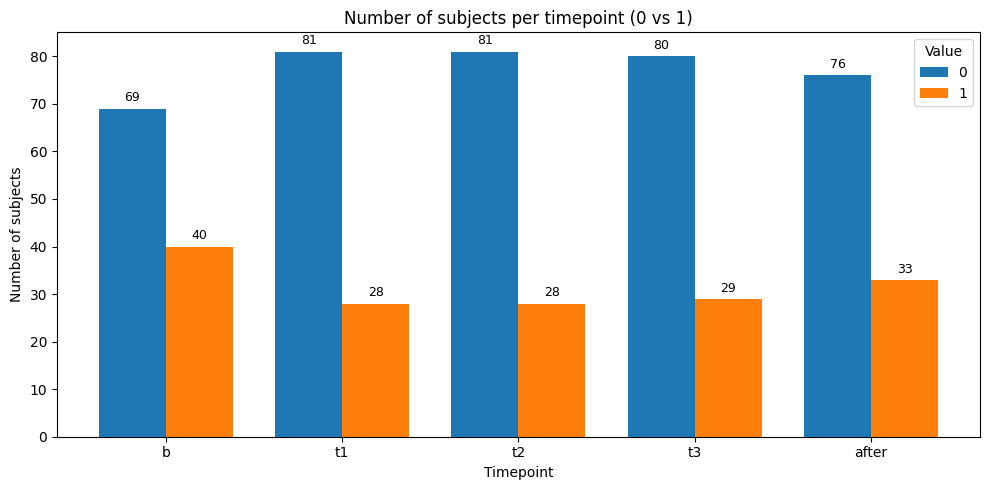

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 👇 Put your file path here
path = r"only_Q_outputs\combined\timepoints_file_inverted_2.csv"

df = pd.read_csv(path)
print(df.columns.tolist())
subject_col = "Subject_Code"
time_cols = [c for c in df.columns if c != subject_col]
count_0 = [(df[c] == 0).sum() for c in time_cols]
count_1 = [(df[c] == 1).sum() for c in time_cols]

x = np.arange(len(time_cols))
width = 0.38

plt.figure(figsize=(10, 5))
bars0 = plt.bar(x - width/2, count_0, width, label="0")
bars1 = plt.bar(x + width/2, count_1, width, label="1")

# ✅ Add numbers above each bar
plt.bar_label(bars0, padding=3, fontsize=9)
plt.bar_label(bars1, padding=3, fontsize=9)

plt.xticks(x, time_cols)
plt.ylabel("Number of subjects")
plt.xlabel("Timepoint")
plt.title("Number of subjects per timepoint (0 vs 1)")
plt.legend(title="Value")
plt.tight_layout()
plt.show()


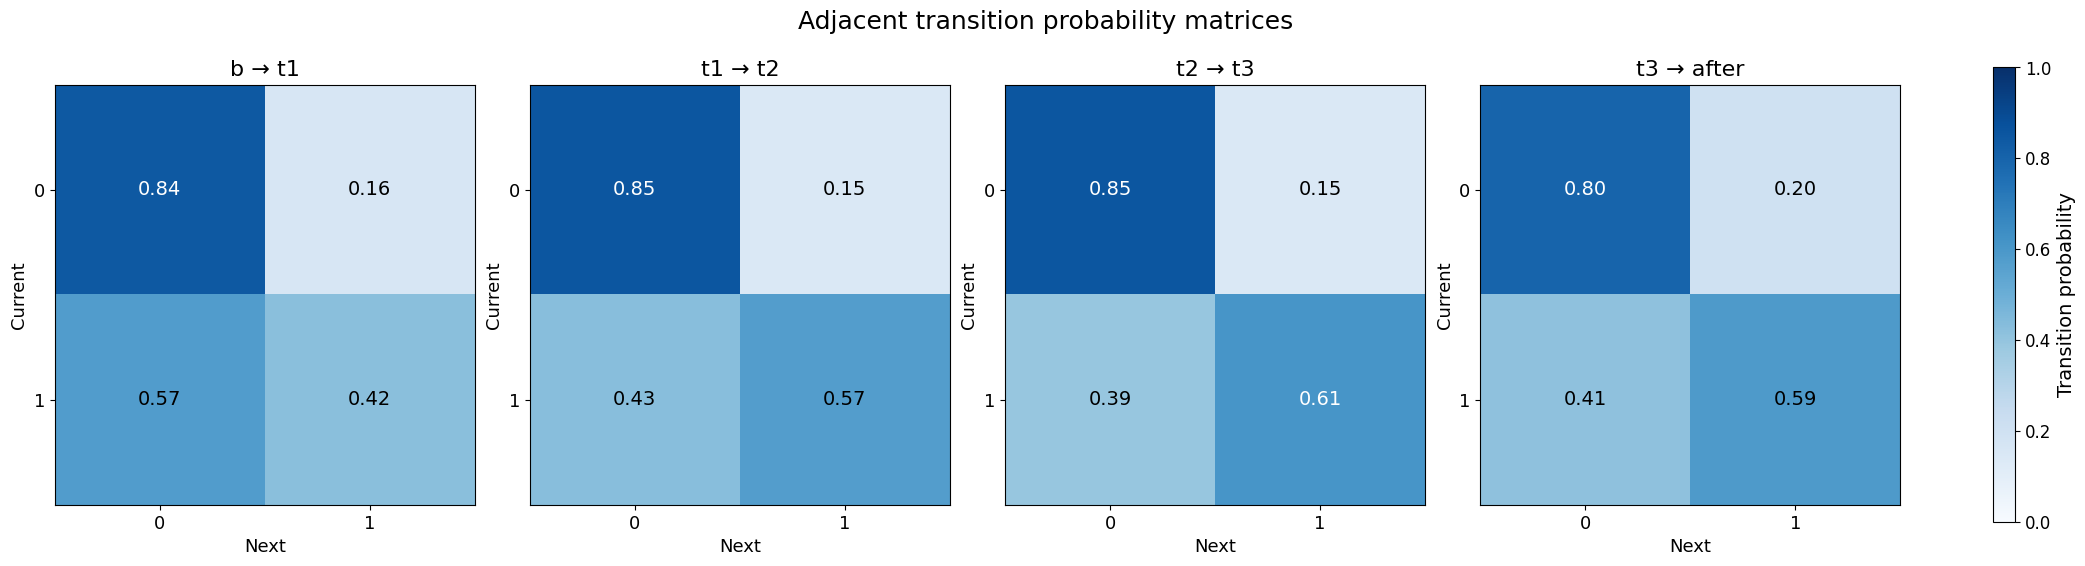

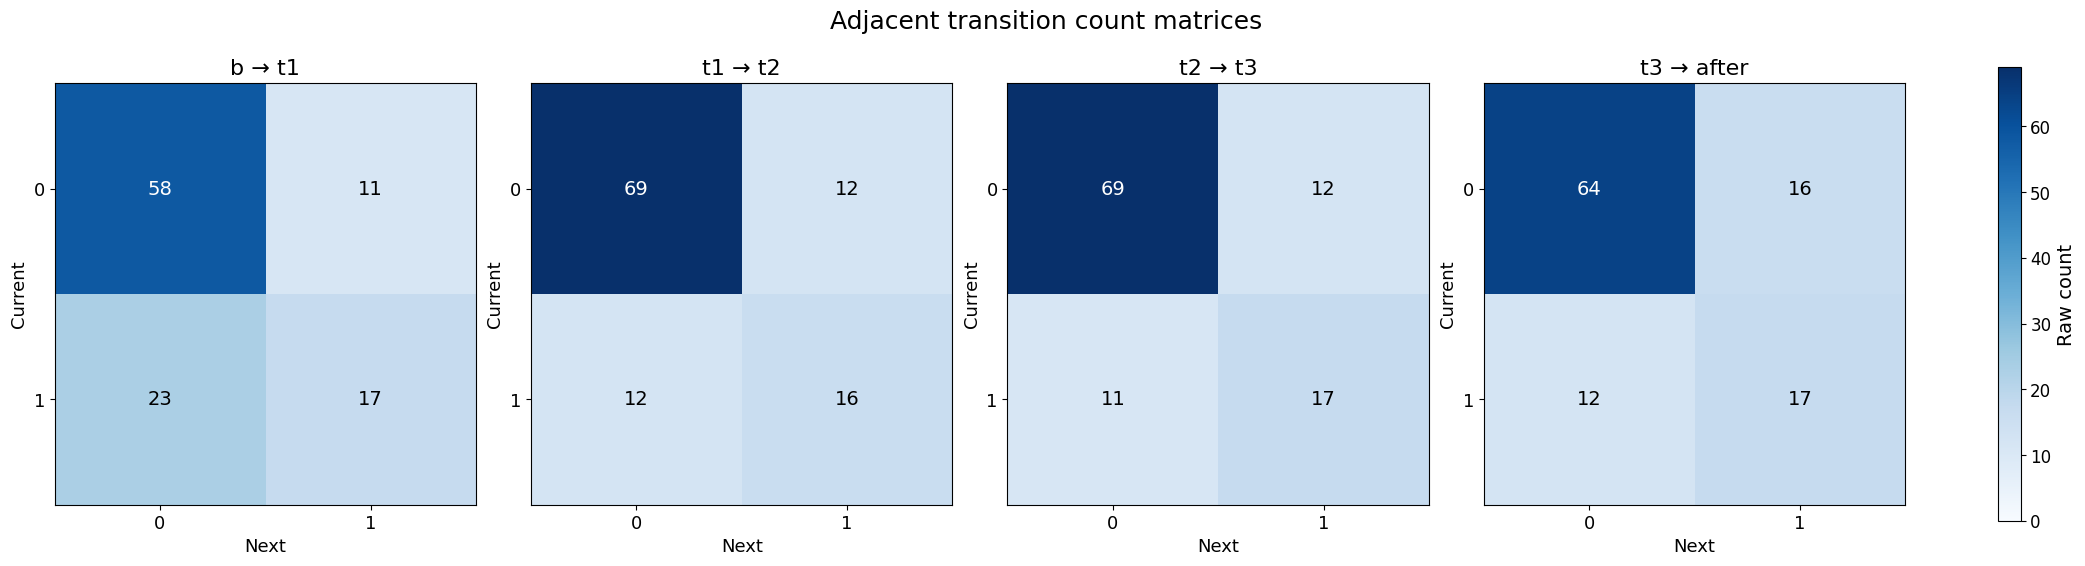

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Path
# =========================
in_path = r"only_Q_outputs\combined\timepoints_file_inverted_2.csv"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load
# =========================
df = pd.read_csv(in_path)

tp_cols = [tp for tp in timepoint_order if tp in df.columns]
if len(tp_cols) < 2:
    raise ValueError(f"Need at least 2 timepoint columns. Found: {tp_cols}")

for tp in tp_cols:
    df[tp] = pd.to_numeric(df[tp], errors="coerce")

states = sorted({int(x) for x in pd.unique(df[tp_cols].values.ravel()) if pd.notna(x)})
if not states:
    raise ValueError("No numeric states found in timepoint columns.")

pairs = list(zip(tp_cols[:-1], tp_cols[1:]))

# =========================
# Compute all matrices first
# =========================
counts_mats = []
prob_mats = []
titles = []

for a, b in pairs:
    sub = df[[a, b]].dropna()

    counts = pd.crosstab(sub[a], sub[b]).reindex(index=states, columns=states, fill_value=0)
    probs = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    counts_mats.append(counts)
    prob_mats.append(probs)
    titles.append(f"{a} → {b}")

# =========================
# Helper: plot matrix with adaptive text color
# =========================
def draw_matrix(ax, mat, title, cmap="Blues", vmin=None, vmax=None,
                text_size=14, tick_size=13, title_size=16,
                fmt="{:.2f}", threshold=0.6):
    im = ax.imshow(mat.values, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=title_size)

    ax.set_xticks(range(len(mat.columns)))
    ax.set_yticks(range(len(mat.index)))

    # ✅ show ticks on ALL matrices
    ax.set_xticklabels(mat.columns, fontsize=tick_size)
    ax.set_yticklabels(mat.index, fontsize=tick_size)

    ax.set_xlabel("Next", fontsize=tick_size)
    ax.set_ylabel("Current", fontsize=tick_size)

    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iat[i, j]
            txt_color = "white" if (vmax is not None and (val / vmax) >= threshold) else "black"
            ax.text(j, i, fmt.format(val), ha="center", va="center",
                    fontsize=text_size, color=txt_color)

    return im

# =========================
# FIGURE 1: Probabilities
# =========================
fig_w = 5.2 * len(pairs)
fig1, axes1 = plt.subplots(1, len(pairs), figsize=(fig_w, 5.6), constrained_layout=True)
if len(pairs) == 1:
    axes1 = [axes1]

last_im = None
for idx, (probs, title) in enumerate(zip(prob_mats, titles)):
    last_im = draw_matrix(
        axes1[idx], probs, title,
        cmap="Blues", vmin=0, vmax=1,
        text_size=14, tick_size=13, title_size=16,
        fmt="{:.2f}",
        threshold=0.6
    )

cbar1 = fig1.colorbar(last_im, ax=axes1, shrink=0.9)
cbar1.set_label("Transition probability", fontsize=14)
cbar1.ax.tick_params(labelsize=12)

fig1.suptitle("Adjacent transition probability matrices", fontsize=18)
plt.show()

# =========================
# FIGURE 2: Counts
# =========================
global_max = max(mat.values.max() for mat in counts_mats)

fig2, axes2 = plt.subplots(1, len(pairs), figsize=(fig_w, 5.6), constrained_layout=True)
if len(pairs) == 1:
    axes2 = [axes2]

last_im2 = None
for idx, (counts, title) in enumerate(zip(counts_mats, titles)):
    last_im2 = draw_matrix(
        axes2[idx], counts, title,
        cmap="Blues", vmin=0, vmax=global_max,
        text_size=14, tick_size=13, title_size=16,
        fmt="{:.0f}",
        threshold=0.6
    )

cbar2 = fig2.colorbar(last_im2, ax=axes2, shrink=0.9)
cbar2.set_label("Raw count", fontsize=14)
cbar2.ax.tick_params(labelsize=12)

fig2.suptitle("Adjacent transition count matrices", fontsize=18)
plt.show()



In [6]:
import pandas as pd
import os

# ----------------
# Paths
# ----------------
in_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"
excel_path = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"   # <-- change this
excel_sheet = 0                          # or "Sheet1"
out_dir = r"only_Q_outputs/combined/timepoint_pair_files_with_meta"
os.makedirs(out_dir, exist_ok=True)

subject_col = "Subject_Code"
after_col = "after"

# ----------------
# Load base (inverted) file
# ----------------
df = pd.read_csv(in_path)

if subject_col not in df.columns:
    raise ValueError(f"'{subject_col}' not found in inverted file. Columns: {list(df.columns)}")
if after_col not in df.columns:
    raise ValueError(f"'{after_col}' not found in inverted file. Columns: {list(df.columns)}")

time_cols = [c for c in df.columns if c not in [subject_col, after_col]]

# ----------------
# Load Excel and choose columns to add
# ----------------
meta = pd.read_excel(excel_path, sheet_name=excel_sheet)

if subject_col not in meta.columns:
    raise ValueError(f"'{subject_col}' not found in Excel file. Columns: {list(meta.columns)}")

# ✅ Choose what to add:
# Option A: add ALL excel columns except Subject_Code

# Option B: add only specific columns (uncomment and set)
cols_to_add = ["b_PHQ_total", "T1_PHQ_total", "T2_PHQ_total","T3_PHQ_total","after_PHQ_total"]

meta_small = meta[[subject_col] + cols_to_add].copy()

# Make sure IDs match type-wise
df[subject_col] = df[subject_col].astype(str)
meta_small[subject_col] = meta_small[subject_col].astype(str)

# ----------------
# Create + merge + save
# ----------------
for tp in time_cols:
    out_df = df[[subject_col, after_col, tp]].copy()

    # merge extra columns from Excel
    out_df = out_df.merge(meta_small, on=subject_col, how="left")

    out_path = os.path.join(out_dir, f"{tp}_and_after_with_meta.csv")
    out_df.to_csv(out_path, index=False)

print(f"Created {len(time_cols)} files in: {out_dir}")


Created 4 files in: only_Q_outputs/combined/timepoint_pair_files_with_meta


In [19]:
import pandas as pd
import os
import glob
import numpy as np

pair_dir = r"only_Q_outputs/combined/timepoint_pair_files_with_meta"  # folder with your files
pattern = "*_and_after_with_meta.csv"  # adjust if your filenames differ
out_summary_path = os.path.join(pair_dir, "phq_transition_summary_from_pair_files.csv")

subject_col = "Subject_Code"
after_col = "after"
after_phq_col = "after_PHQ_total"

def phq_col_for_timepoint(tp: str, cols) -> str:
    """
    Find the PHQ total column corresponding to the timepoint indicator column `tp`.
    Examples:
      tp='b'  -> 'b_PHQ_total'
      tp='t1' -> 'T1_PHQ_total' (or 't1_PHQ_total' if that's what you have)
    """
    candidates = [
        f"{tp}_PHQ_total",
        f"{tp.upper()}_PHQ_total",
        f"{tp.capitalize()}_PHQ_total",
    ]
    # handle t1/t2/t3 -> T1/T2/T3 style
    if tp.lower().startswith("t") and len(tp) > 1 and tp[1:].isdigit():
        candidates.insert(0, f"T{tp[1:]}_PHQ_total")

    for c in candidates:
        if c in cols:
            return c
    raise ValueError(f"Could not find PHQ column for timepoint '{tp}'. Tried: {candidates}")

rows = []

for f in sorted(glob.glob(os.path.join(pair_dir, pattern))):
    df = pd.read_csv(f)

    # tp name from filename: "b_and_after_with_meta.csv" -> "b"
    base = os.path.basename(f)
    tp = base.split("_and_after")[0]

    # checks
    if tp not in df.columns:
        raise ValueError(f"In file {base}, expected timepoint column '{tp}' but it wasn't found. Columns: {list(df.columns)}")
    if after_col not in df.columns:
        raise ValueError(f"In file {base}, missing '{after_col}' column.")
    if after_phq_col not in df.columns:
        raise ValueError(f"In file {base}, missing '{after_phq_col}' column.")

    prev_phq_col = phq_col_for_timepoint(tp, df.columns)

    # transition group: previous timepoint == 0 AND after == 1
    mask = (df[tp] == 0) & (df[after_col] == 1)
    n = int(mask.sum())

    prev_mean = df.loc[mask, prev_phq_col].mean() if n > 0 else np.nan
    after_mean = df.loc[mask, after_phq_col].mean() if n > 0 else np.nan
    delta = (after_mean - prev_mean) if pd.notna(prev_mean) and pd.notna(after_mean) else np.nan

    rows.append({
        "file": base,
        "timepoint": tp,
        "n_transition_0_to_1": n,
        "mean_PHQ_at_timepoint": prev_mean,
        "mean_PHQ_at_after": after_mean,
        "mean_delta_after_minus_timepoint": delta
    })

summary = pd.DataFrame(rows)
summary.to_csv(out_summary_path, index=False)

print("Saved summary to:", out_summary_path)
print(summary)


Saved summary to: only_Q_outputs/combined/timepoint_pair_files_with_meta\phq_transition_summary_from_pair_files.csv
                         file timepoint  n_transition_0_to_1  \
0   b_and_after_with_meta.csv         b                   15   
1  t1_and_after_with_meta.csv        t1                   15   
2  t2_and_after_with_meta.csv        t2                   15   
3  t3_and_after_with_meta.csv        t3                   16   

   mean_PHQ_at_timepoint  mean_PHQ_at_after  mean_delta_after_minus_timepoint  
0               4.000000           8.933333                          4.933333  
1               6.666667           9.666667                          3.000000  
2               5.133333           8.533333                          3.400000  
3               6.312500           8.750000                          2.437500  


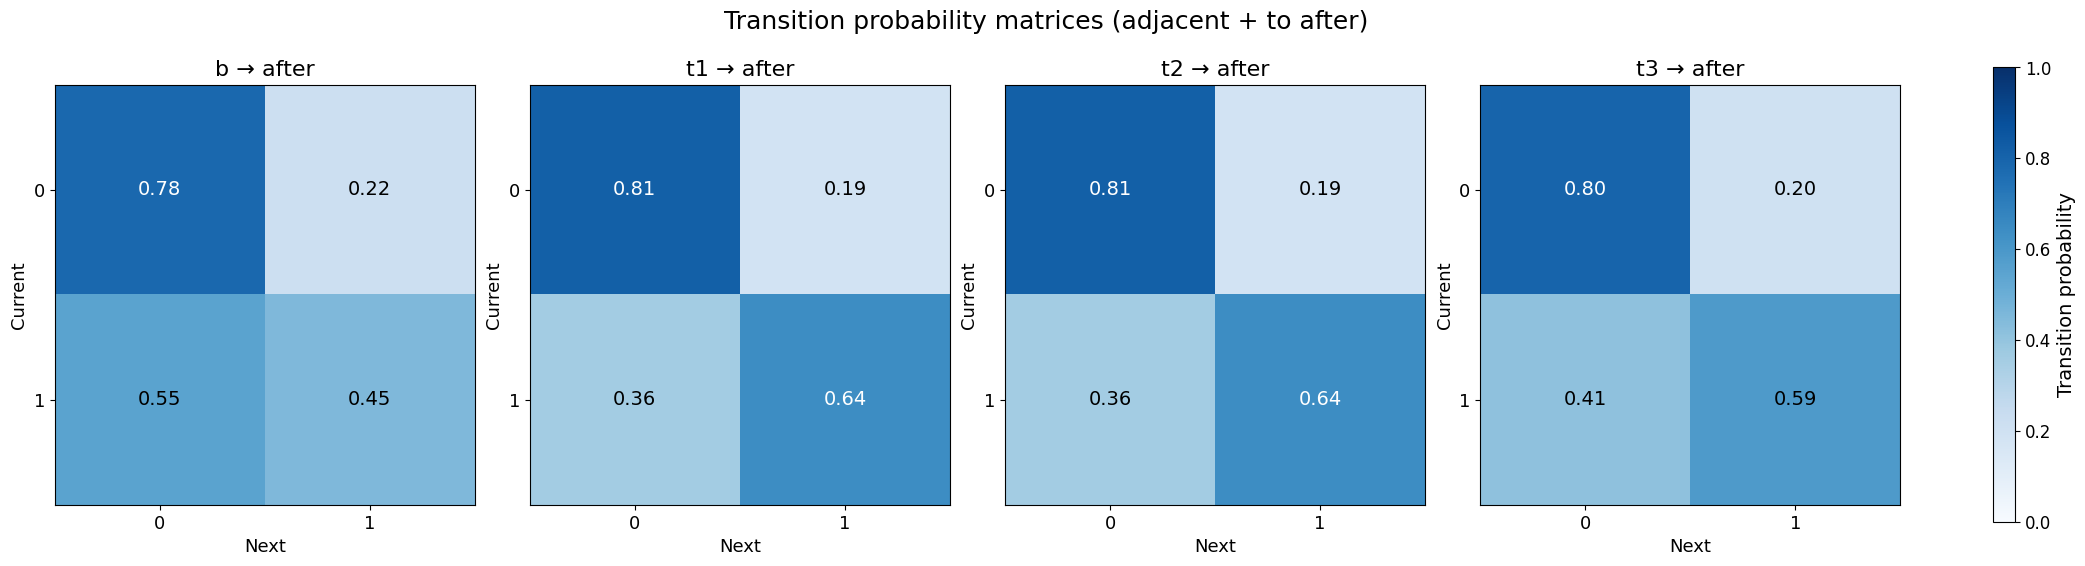

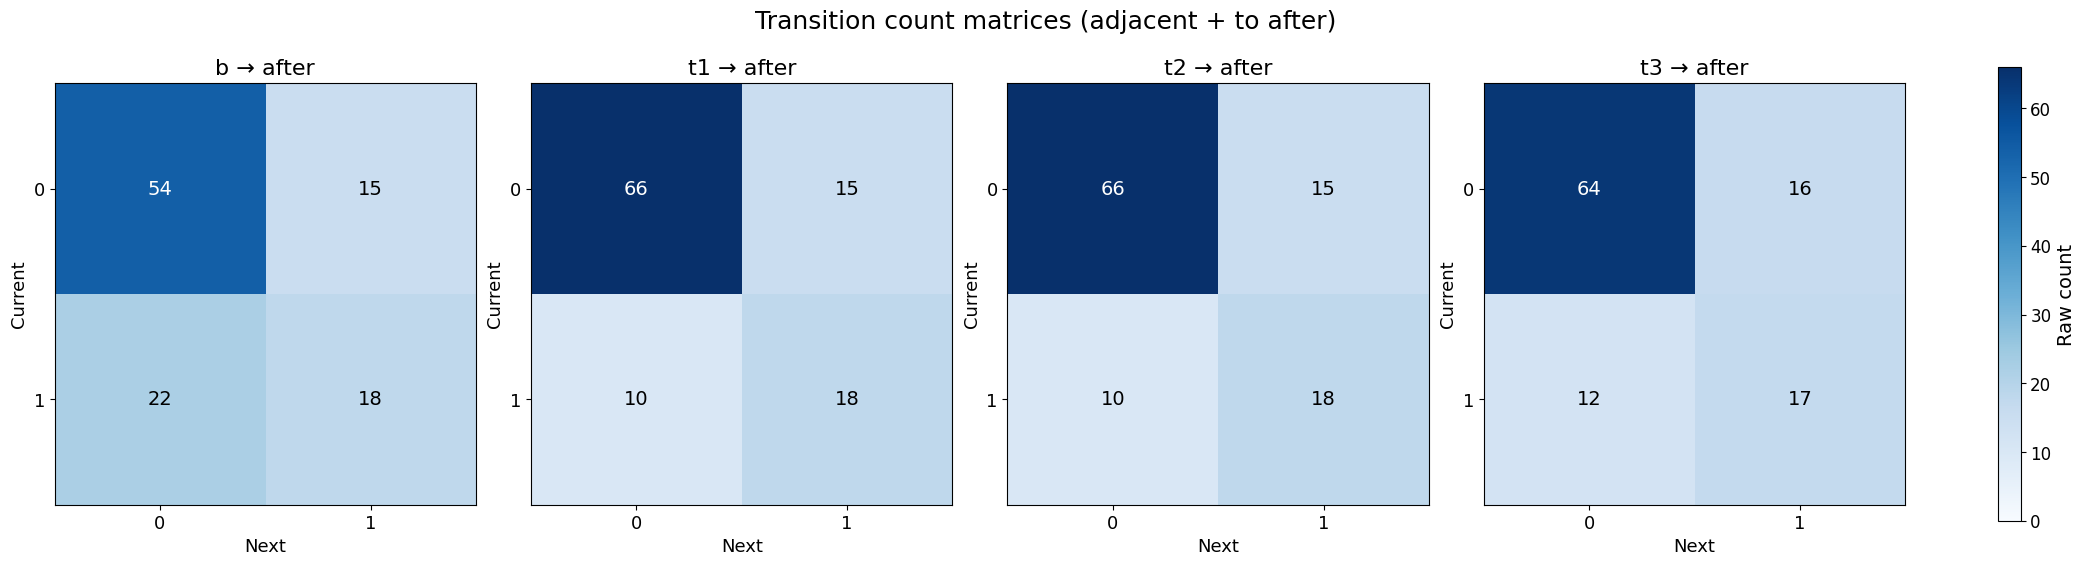

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Path + settings
# =========================
in_path = r"only_Q_outputs\combined\timepoints_file_inverted_2.csv"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load
# =========================
df = pd.read_csv(in_path)

tp_cols = [tp for tp in timepoint_order if tp in df.columns]
if len(tp_cols) < 2:
    raise ValueError(f"Need at least 2 timepoint columns. Found: {tp_cols}")

for tp in tp_cols:
    df[tp] = pd.to_numeric(df[tp], errors="coerce")

states = sorted({int(x) for x in pd.unique(df[tp_cols].values.ravel()) if pd.notna(x)})
if not states:
    raise ValueError("No numeric states found in timepoint columns.")

# =========================
# Build pairs:
# 1) adjacent pairs (b->t1, t1->t2, ...)
# 2) each timepoint -> after (b->after, t1->after, ...)
# =========================
pairs_adj = list(zip(tp_cols[:-1], tp_cols[1:]))

if "after" not in tp_cols:
    raise ValueError("'after' column not found in the file.")

pairs_to_after = [(tp, "after") for tp in tp_cols if tp != "after"]

# Combine, avoid duplicates (t3->after is already adjacent)
pairs =  [p for p in pairs_to_after ]

# =========================
# Compute all matrices first
# =========================
counts_mats = []
prob_mats = []
titles = []

for a, b in pairs:
    sub = df[[a, b]].dropna()

    counts = pd.crosstab(sub[a], sub[b]).reindex(index=states, columns=states, fill_value=0)
    probs = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

    counts_mats.append(counts)
    prob_mats.append(probs)
    titles.append(f"{a} → {b}")

# =========================
# Helper: plot matrix with adaptive text color
# =========================
def draw_matrix(ax, mat, title, cmap="Blues", vmin=None, vmax=None,
                text_size=14, tick_size=13, title_size=16,
                fmt="{:.2f}", threshold=0.6):
    im = ax.imshow(mat.values, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title, fontsize=title_size)

    ax.set_xticks(range(len(mat.columns)))
    ax.set_yticks(range(len(mat.index)))

    # show ticks on ALL matrices
    ax.set_xticklabels(mat.columns, fontsize=tick_size)
    ax.set_yticklabels(mat.index, fontsize=tick_size)

    ax.set_xlabel("Next", fontsize=tick_size)
    ax.set_ylabel("Current", fontsize=tick_size)

    # adaptive text color
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iat[i, j]
            txt_color = "white" if (vmax is not None and vmax != 0 and (val / vmax) >= threshold) else "black"
            ax.text(j, i, fmt.format(val), ha="center", va="center",
                    fontsize=text_size, color=txt_color)

    return im

# =========================
# FIGURE 1: Probabilities
# =========================
fig_w = 5.2 * len(pairs)
fig1, axes1 = plt.subplots(1, len(pairs), figsize=(fig_w, 5.6), constrained_layout=True)
if len(pairs) == 1:
    axes1 = [axes1]

last_im = None
for idx, (probs, title) in enumerate(zip(prob_mats, titles)):
    last_im = draw_matrix(
        axes1[idx], probs, title,
        cmap="Blues", vmin=0, vmax=1,
        text_size=14, tick_size=13, title_size=16,
        fmt="{:.2f}",
        threshold=0.6
    )

cbar1 = fig1.colorbar(last_im, ax=axes1, shrink=0.9)
cbar1.set_label("Transition probability", fontsize=14)
cbar1.ax.tick_params(labelsize=12)

fig1.suptitle("Transition probability matrices (adjacent + to after)", fontsize=18)
plt.show()

# =========================
# FIGURE 2: Counts
# =========================
global_max = max(mat.values.max() for mat in counts_mats) if counts_mats else 1

fig2, axes2 = plt.subplots(1, len(pairs), figsize=(fig_w, 5.6), constrained_layout=True)
if len(pairs) == 1:
    axes2 = [axes2]

last_im2 = None
for idx, (counts, title) in enumerate(zip(counts_mats, titles)):
    last_im2 = draw_matrix(
        axes2[idx], counts, title,
        cmap="Blues", vmin=0, vmax=global_max,
        text_size=14, tick_size=13, title_size=16,
        fmt="{:.0f}",
        threshold=0.6
    )

cbar2 = fig2.colorbar(last_im2, ax=axes2, shrink=0.9)
cbar2.set_label("Raw count", fontsize=14)
cbar2.ax.tick_params(labelsize=12)

fig2.suptitle("Transition count matrices (adjacent + to after)", fontsize=18)
plt.show()


# analsyis with the seperators 

## find the line that seperate the clusters at each time point

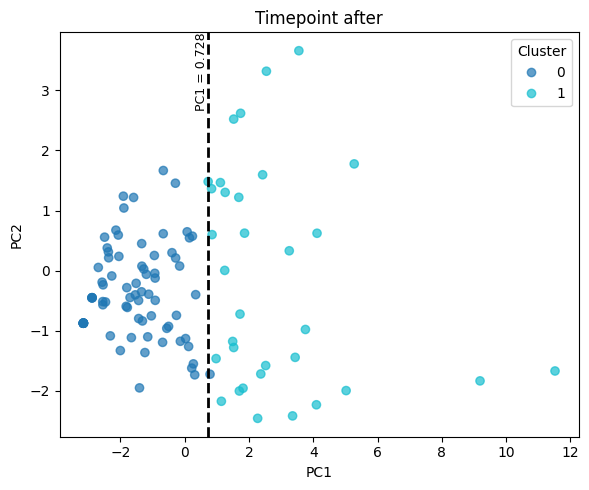

after: separator = 0.728146


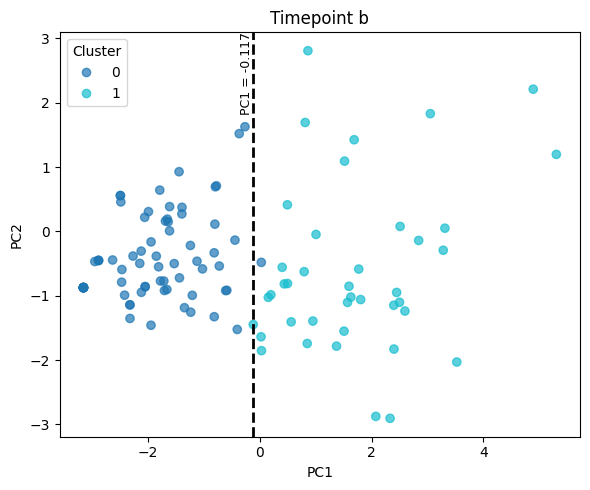

b: separator = -0.116535


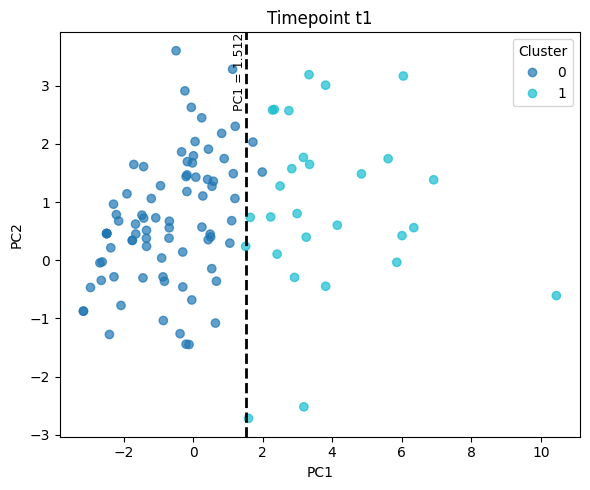

t1: separator = 1.512484


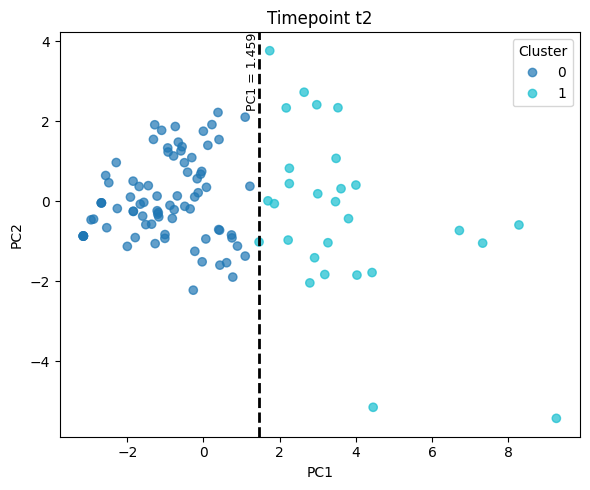

t2: separator = 1.458651


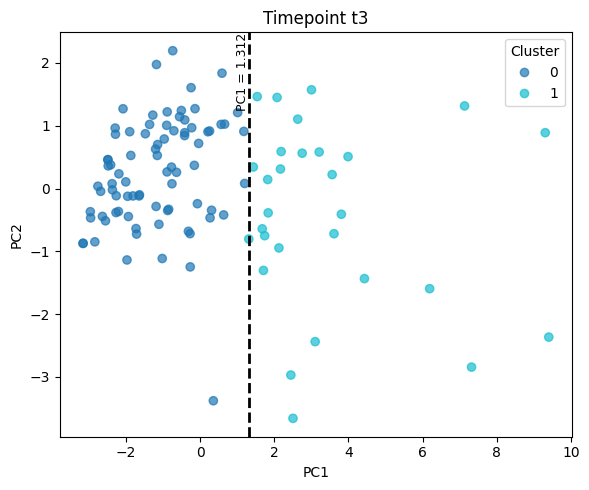

t3: separator = 1.312326


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# Path
# =========================
data_dir = Path(r"only_Q_outputs\combined\timepoint_files")

# =========================
# Collect timepoint files
# =========================
files = sorted(data_dir.glob("timepoint_*.csv"))

separators = {}

# =========================
# Loop over timepoints
# =========================
for file in files:

    # ---- extract timepoint name ----
    tp = file.stem.replace("timepoint_", "")

    # ---- load data ----
    df = pd.read_csv(file)

    # =========================
    # Find separator
    # =========================
    cluster1 = df[df["cluster"] == 1]

    if cluster1.empty:
        raise ValueError(f"No cluster 1 subjects in {tp}")

    separator = cluster1["PC1"].min()
    separators[tp] = separator

    # =========================
    # Plot
    # =========================
    plt.figure(figsize=(6, 5))

    scatter = plt.scatter(
        df["PC1"],
        df["PC2"],
        c=df["cluster"],
        cmap="tab10",
        alpha=0.7
    )

    # vertical separator line
    plt.axvline(
        separator,
        linestyle="--",
        linewidth=2,
        color="black"
    )

    # --- annotate separator value on plot ---
    y_min, y_max = plt.ylim()
    plt.text(
        separator,
        y_max,
        f"PC1 = {separator:.3f}",
        rotation=90,
        verticalalignment="top",
        horizontalalignment="right",
        fontsize=9,
        color="black"
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"Timepoint {tp}")

    # legend
    plt.legend(
        *scatter.legend_elements(),
        title="Cluster"
    )

    plt.tight_layout()
    plt.show()

    # --- print separator value ---
    print(f"{tp}: separator = {separator:.6f}")


## drawing all the separators together on the pca data  

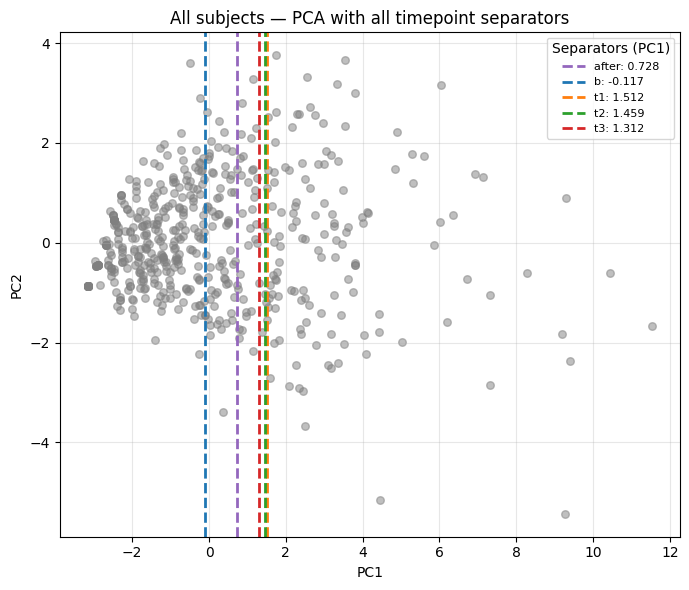


All separators:
after: 0.728146
b: -0.116535
t1: 1.512484
t2: 1.458651
t3: 1.312326
Saved separators file to: only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv
  timepoint  PC1_separator
1         b      -0.116535
2        t1       1.512484
3        t2       1.458651
4        t3       1.312326
0     after       0.728146


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# Paths
# =========================
data_dir = Path(r"only_Q_outputs\combined\timepoint_files")
params_path = Path(r"only_Q_outputs\combined\total_clinical_parameters.csv")

# =========================
# Load parameters
# =========================
params = pd.read_csv(params_path)

subject_col = "Subject_Code"

param_cols = [ 'after_bits_PTSD_total', 'after_MPAS_total', 'after_DES_total', 'after_CTQ_total', 'after_DERS_total', 'after_LHQ_total']
tp_colors = {
    "b": "tab:blue",
    "t1": "tab:orange",
    "t2": "tab:green",
    "t3": "tab:red",
    "after": "tab:purple"
}


# =========================
# Load ALL timepoints
# =========================
dfs = []
separators = {}

files = sorted(data_dir.glob("timepoint_*.csv"))

for file in files:
    tp = file.stem.replace("timepoint_", "")
    df = pd.read_csv(file)
    df["timepoint"] = tp
    dfs.append(df)

    cluster1 = df[df["cluster"] == 1]
    if cluster1.empty:
        raise ValueError(f"No cluster 1 subjects in {tp}")

    separators[tp] = cluster1["PC1"].min()

df_all = pd.concat(dfs, ignore_index=True)

# =========================
# Merge parameters ONCE
# =========================
df_all = df_all.merge(
    params[[subject_col] + param_cols],
    on=subject_col,
    how="left"
)
# =========================
# Final plot: ALL points + ALL separators (colored)
# =========================

plt.figure(figsize=(7, 6))

# plot all points (no clusters)
plt.scatter(
    df_all["PC1"],
    df_all["PC2"],
    color="gray",
    alpha=0.5,
    s=30
)

# draw all separators with fixed colors
for tp, separator in separators.items():

    color = tp_colors.get(tp, "black")  # fallback if tp not in dict

    plt.axvline(
        separator,
        linestyle="--",
        linewidth=2,
        color=color,
        label=f"{tp}: {separator:.3f}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("All subjects — PCA with all timepoint separators")

plt.legend(title="Separators (PC1)", fontsize=8)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAll separators:")
for tp, separator in separators.items():
    print(f"{tp}: {separator:.6f}")


# =========================
# Save separators to CSV
# =========================
separators_df = (
    pd.DataFrame(list(separators.items()), columns=["timepoint", "PC1_separator"])
      .assign(timepoint=lambda d: pd.Categorical(d["timepoint"], categories=timepoint_order, ordered=True))
      .sort_values("timepoint")
)

out_sep_path = data_dir / "pc1_separators_by_timepoint.csv"
separators_df.to_csv(out_sep_path, index=False)

print(f"Saved separators file to: {out_sep_path}")
print(separators_df)


## check how the the total after the pregnancy change over the combined pca with the b threshold


===== Coloring by after_bits_PTSD_total (timepoint b only) =====


C:\Users\nogag\AppData\Local\Temp\ipykernel_19496\1136757997.py:146: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Trajectories", fontsize=8)


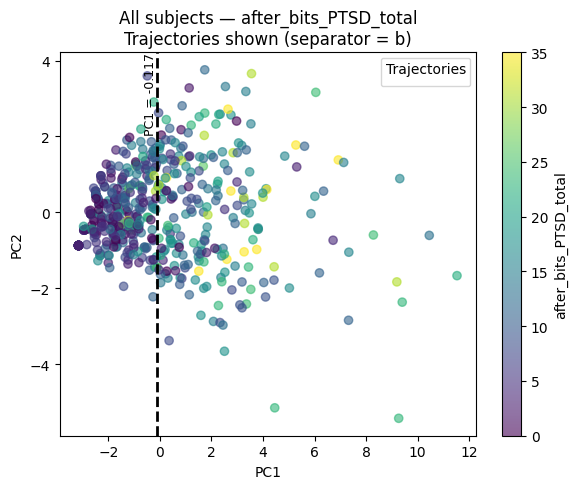

after_bits_PTSD_total | b: separator = -0.116535

===== Coloring by after_MPAS_total (timepoint b only) =====


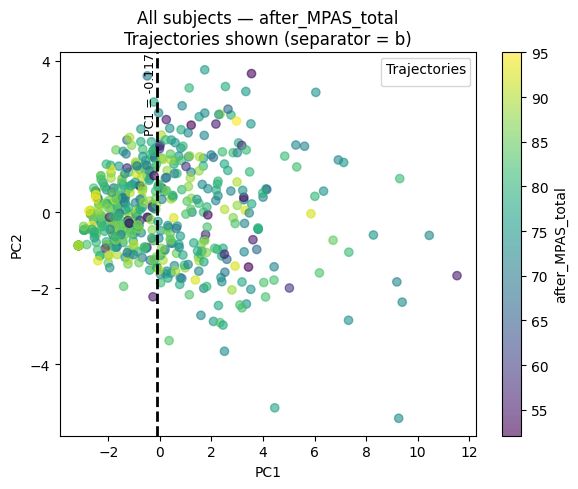

after_MPAS_total | b: separator = -0.116535

===== Coloring by after_CTQ_total (timepoint b only) =====


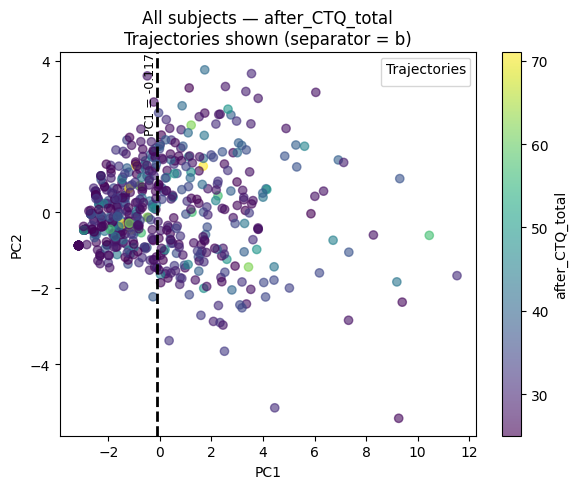

after_CTQ_total | b: separator = -0.116535

===== Coloring by after_DERS_total (timepoint b only) =====


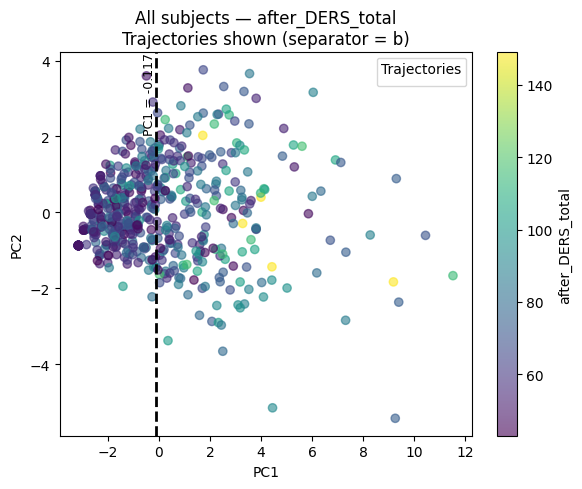

after_DERS_total | b: separator = -0.116535

===== Coloring by after_LHQ_total (timepoint b only) =====


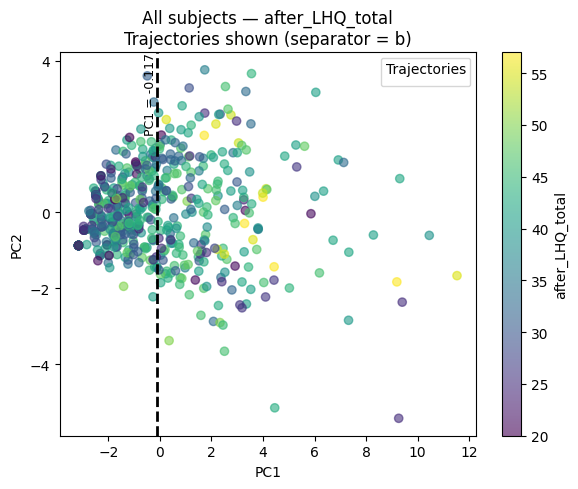

after_LHQ_total | b: separator = -0.116535


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.cm as cm

# =========================
# Paths
# =========================
data_dir = Path(r"only_Q_outputs\combined\timepoint_files")
params_path = Path(r"only_Q_outputs\combined\total_clinical_parameters.csv")

# =========================
# Load parameters
# =========================
params = pd.read_csv(params_path)

subject_col = "Subject_Code"

param_cols = [ 'after_bits_PTSD_total',  'after_MPAS_total', 'after_CTQ_total', 'after_DERS_total', 
 'after_LHQ_total']
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load ALL timepoints
# =========================
dfs = []
separators = {}

files = sorted(data_dir.glob("timepoint_*.csv"))

for file in files:
    tp = file.stem.replace("timepoint_", "")
    df = pd.read_csv(file)
    df["timepoint"] = tp
    dfs.append(df)

    cluster1 = df[df["cluster"] == 1]
    if cluster1.empty:
        raise ValueError(f"No cluster 1 subjects in {tp}")

    separators[tp] = cluster1["PC1"].min()

df_all = pd.concat(dfs, ignore_index=True)
# pick first 5 unique subjects
trajectory_subjects = df_all[subject_col].dropna().unique()[:5]

# =========================
# Merge parameters ONCE
# =========================
df_all = df_all.merge(
    params[[subject_col] + param_cols],
    on=subject_col,
    how="left"

)


trajectory_subjects = df_all[subject_col].dropna().unique()[:5]

traj_colors = {
    subj: cm.tab10(i % 10)
    for i, subj in enumerate(trajectory_subjects)
}

timepoint_order = ["b", "t1", "t2", "t3", "after"]
# =========================
# Plot: ONLY for timepoint b
# =========================
for param_col in param_cols:

    print(f"\n===== Coloring by {param_col} (timepoint b only) =====")

    tp = "b"
    separator = separators[tp]

    plt.figure(figsize=(6, 5))

    # ---- scatter of all points ----
    sc = plt.scatter(
        df_all["PC1"],
        df_all["PC2"],
        c=df_all[param_col],
        cmap="viridis",
        alpha=0.6
    )

    # ---- separator (ONLY b) ----
    plt.axvline(separator, linestyle="--", linewidth=2, color="black")

    y_min, y_max = plt.ylim()
    plt.text(
        separator,
        y_max,
        f"PC1 = {separator:.3f}",
        rotation=90,
        va="top",
        ha="right",
        fontsize=9
    )

    # =========================
    # Trajectories (colored)
    # =========================
    # for subj in trajectory_subjects:

    #     df_subj = df_all[df_all[subject_col] == subj].copy()

    #     df_subj = df_subj[df_subj["timepoint"].isin(timepoint_order)]
    #     df_subj["timepoint"] = pd.Categorical(
    #         df_subj["timepoint"],
    #         categories=timepoint_order,
    #         ordered=True
    #     )
    #     df_subj = df_subj.sort_values("timepoint")

    #     if len(df_subj) < 2:
    #         continue

    #     color = traj_colors[subj]

    #     # line
    #     plt.plot(
    #         df_subj["PC1"],
    #         df_subj["PC2"],
    #         color=color,
    #         linewidth=2,
    #         alpha=0.9,
    #         zorder=3
    #     )

    #     # points
    #     plt.scatter(
    #         df_subj["PC1"],
    #         df_subj["PC2"],
    #         color=color,
    #         s=50,
    #         zorder=4,
    #         label=f"Subject {subj}"
    #     )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"All subjects — {param_col}\nTrajectories shown (separator = b)")

    plt.colorbar(sc, label=param_col)
    plt.legend(title="Trajectories", fontsize=8)

    plt.tight_layout()
    plt.show()

    print(f"{param_col} | b: separator = {separator:.6f}")



===== Coloring by after_bits_PTSD_total (all separators) =====


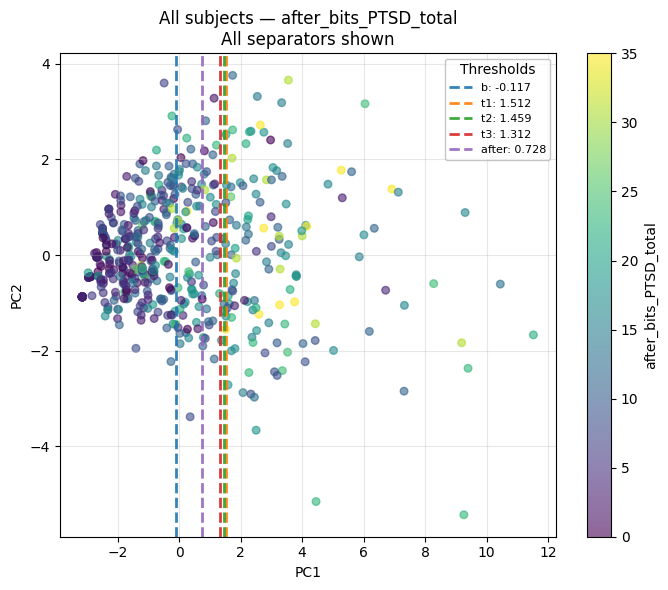

after_bits_PTSD_total | b: separator = -0.116535
after_bits_PTSD_total | t1: separator = 1.512484
after_bits_PTSD_total | t2: separator = 1.458651
after_bits_PTSD_total | t3: separator = 1.312326
after_bits_PTSD_total | after: separator = 0.728146

===== Coloring by after_MPAS_total (all separators) =====


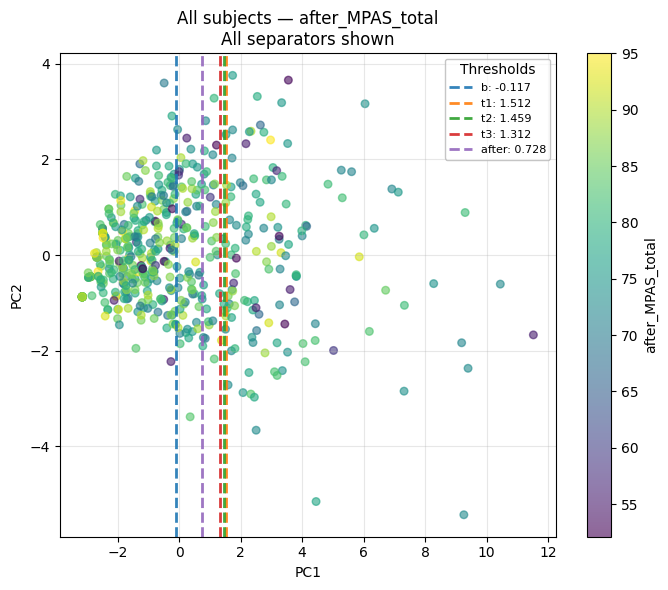

after_MPAS_total | b: separator = -0.116535
after_MPAS_total | t1: separator = 1.512484
after_MPAS_total | t2: separator = 1.458651
after_MPAS_total | t3: separator = 1.312326
after_MPAS_total | after: separator = 0.728146


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.cm as cm

# =========================
# Paths
# =========================
data_dir = Path(r"only_Q_outputs\combined\timepoint_files")
params_path = Path(r"only_Q_outputs\combined\total_clinical_parameters.csv")

# =========================
# Load parameters
# =========================
params = pd.read_csv(params_path)

subject_col = "Subject_Code"
param_cols = ['after_bits_PTSD_total', 'after_MPAS_total']
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load ALL timepoints
# =========================
dfs = []
separators = {}

files = sorted(data_dir.glob("timepoint_*.csv"))

for file in files:
    tp = file.stem.replace("timepoint_", "")
    df = pd.read_csv(file)
    df["timepoint"] = tp
    dfs.append(df)

    cluster1 = df[df["cluster"] == 1]
    if cluster1.empty:
        raise ValueError(f"No cluster 1 subjects in {tp}")

    separators[tp] = cluster1["PC1"].min()

df_all = pd.concat(dfs, ignore_index=True)

# =========================
# Merge parameters ONCE
# =========================
df_all = df_all.merge(
    params[[subject_col] + param_cols],
    on=subject_col,
    how="left"
)

# =========================
# Plot: ALL separators for all timepoints
# (threshold labels in the legend, not on the lines)
# =========================
for param_col in param_cols:

    print(f"\n===== Coloring by {param_col} (all separators) =====")

    plt.figure(figsize=(7, 6))
    # ---- scatter of all points ----
    sc = plt.scatter(
        df_all["PC1"],
        df_all["PC2"],
        c=df_all[param_col],
        cmap="viridis",
        alpha=0.6,
        s=30
    )

    # ---- separators in different colors ----
    for tp in timepoint_order:
        if tp in separators:
            separator = separators[tp]
            plt.axvline(
                separator,
                linestyle="--",
                linewidth=2,
                color=tp_colors.get(tp, "black"),
                alpha=0.9,
                zorder=2,
                label=f"{tp}: {separator:.3f}"
            )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"All subjects — {param_col}\nAll separators shown")

    # keep the clinical parameter colorbar
    plt.colorbar(sc, label=param_col)

    # legend INSIDE the plot (with translucent background)
    leg = plt.legend(
        title="Thresholds",
        fontsize=8,
        loc="upper right",   # try "upper left" if you prefer
        frameon=True
    )
    leg.get_frame().set_alpha(0.75)   # makes points visible under legend
    leg.get_frame().set_edgecolor("0.7")

    plt.grid(alpha=0.3)




    plt.tight_layout()
    plt.show()

    # Print all separators
    for tp in timepoint_order:
        if tp in separators:
            print(f"{param_col} | {tp}: separator = {separators[tp]:.6f}")


Loaded thresholds:
  b (before) : -0.116535
  t1  (t1)     : 1.512484


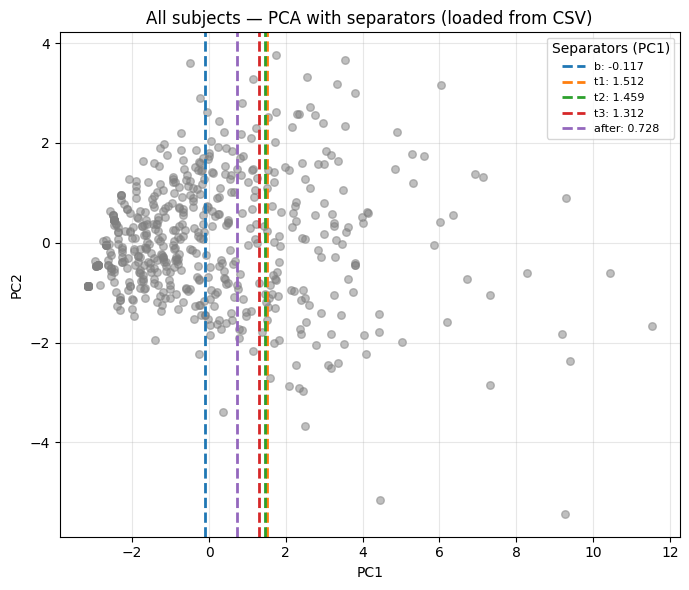


Position value counts:
position
0    311
1    130
2    104
Name: count, dtype: int64

Saved positions file to: only_Q_outputs\combined\subject_positions_by_thresholds.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# =========================
# Paths
# =========================
data_dir = Path(r"only_Q_outputs\combined\timepoint_files")
params_path = Path(r"only_Q_outputs\combined\total_clinical_parameters.csv")

# separators file you already created
sep_path = data_dir / "pc1_separators_by_timepoint.csv"
# If you are running in this notebook environment instead, you can use:
# sep_path = Path("/mnt/data/pc1_separators_by_timepoint.csv")

out_positions_path = Path(r"only_Q_outputs\combined\subject_positions_by_thresholds.csv")

# =========================
# Settings
# =========================
subject_col = "Subject_Code"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

param_cols = [
    "after_bits_PTSD_total",
    "after_MPAS_total"
]

tp_colors = {
    "b": "tab:blue",
    "t1": "tab:orange",
    "t2": "tab:green",
    "t3": "tab:red",
    "after": "tab:purple"
}

# Threshold timepoints to use
TP_BEFORE = "b"
TP_FIRST  = "t1"

# =========================
# Load parameters
# =========================
params = pd.read_csv(params_path)

# =========================
# Load ALL timepoints
# =========================
dfs = []
files = sorted(data_dir.glob("timepoint_*.csv"))
if not files:
    raise FileNotFoundError(f"No files matched: {data_dir / 'timepoint_*.csv'}")

for file in files:
    tp = file.stem.replace("timepoint_", "")
    df = pd.read_csv(file)
    df["timepoint"] = tp
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)

# =========================
# Merge clinical parameters
# =========================
df_all = df_all.merge(
    params[[subject_col] + param_cols],
    on=subject_col,
    how="left"
)

# =========================
# Load separators from your CSV
# =========================
if not sep_path.exists():
    raise FileNotFoundError(f"Separators file not found at: {sep_path}")

separators_df = pd.read_csv(sep_path)

required_cols = {"timepoint", "PC1_separator"}
if not required_cols.issubset(separators_df.columns):
    raise ValueError(f"{sep_path} must contain columns {required_cols}, got {list(separators_df.columns)}")

separators = dict(zip(separators_df["timepoint"], separators_df["PC1_separator"]))

missing = [tp for tp in [TP_BEFORE, TP_FIRST] if tp not in separators]
if missing:
    raise KeyError(f"Missing separators for: {missing}. Available: {sorted(separators.keys())}")

thr_before = float(separators[TP_BEFORE])
thr_first  = float(separators[TP_FIRST])

print("Loaded thresholds:")
print(f"  {TP_BEFORE} (before) : {thr_before:.6f}")
print(f"  {TP_FIRST}  (t1)     : {thr_first:.6f}")

# =========================
# Optional plot: ALL points + separators (loaded)
# =========================
plt.figure(figsize=(7, 6))
plt.scatter(df_all["PC1"], df_all["PC2"], color="gray", alpha=0.5, s=30)

for tp in timepoint_order:
    if tp in separators:
        sep = float(separators[tp])
        plt.axvline(
            sep,
            linestyle="--",
            linewidth=2,
            color=tp_colors.get(tp, "black"),
            label=f"{tp}: {sep:.3f}"
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("All subjects — PCA with separators (loaded from CSV)")
plt.legend(title="Separators (PC1)", fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# =========================
# Position rule (UPDATED)
# 0 if PC1 < thr_before
# 2 if thr_before <= PC1 < thr_first
# 1 if PC1 >= thr_first
# =========================
def position_from_pc1(pc1):
    if pd.isna(pc1):
        return np.nan
    if pc1 < thr_before:
        return 0
    elif pc1 < thr_first:
        return 2
    else:
        return 1

# =========================
# Build output file
# Columns: Subject_Code, timepoint, position, + clinical params
# =========================
df_out = df_all[[subject_col, "timepoint", "PC1"] + param_cols].copy()
df_out["position"] = df_out["PC1"].apply(position_from_pc1)

# keep only requested columns
df_out = df_out[[subject_col, "timepoint", "position"] + param_cols].copy()

# sort nicely
df_out["timepoint"] = pd.Categorical(df_out["timepoint"], categories=timepoint_order, ordered=True)
df_out = df_out.sort_values([subject_col, "timepoint"]).reset_index(drop=True)

# quick sanity check
print("\nPosition value counts:")
print(df_out["position"].value_counts(dropna=False))

# save
out_positions_path.parent.mkdir(parents=True, exist_ok=True)
df_out.to_csv(out_positions_path, index=False)
print(f"\nSaved positions file to: {out_positions_path}")


In [ ]:
import pandas as pd

in_path = r"only_Q_outputs\combined\subject_positions_by_thresholds.csv"  # your uploaded file
df = pd.read_csv(in_path)

# choose the columns you care about (rename if needed)
bits_col = "after_bits_PTSD_total"
mpas_col = "after_MPAS_total"

means_by_position = (
    df.groupby("position")[[bits_col, mpas_col]]
      .mean(numeric_only=True)
      .reset_index()
      .sort_values("position")
)

counts_by_position = (
    df.groupby("position")[bits_col]
      .size()
      .reset_index(name="n_rows")
      .sort_values("position")
)

print("Means by position (row-level):")
print(means_by_position)
print("\nCounts:")
print(counts_by_position)


import pandas as pd
from scipy import stats

in_path = r"only_Q_outputs\combined\subject_positions_by_thresholds.csv"  # your uploaded file
df = pd.read_csv(in_path)

# choose the columns you care about (rename if needed)
bits_col = "after_bits_PTSD_total"
mpas_col = "after_MPAS_total"

means_by_position = (
    df.groupby("position")[[bits_col, mpas_col]]
      .mean(numeric_only=True)
      .reset_index()
      .sort_values("position")
)

counts_by_position = (
    df.groupby("position")[bits_col]
      .size()
      .reset_index(name="n_rows")
      .sort_values("position")
)

print("Means by position (row-level):")
print(means_by_position)
print("\nCounts:")
print(counts_by_position)

# =========================
# T-test between position 0 and position 1
# =========================
print("\n" + "="*60)
print("T-TESTS: Position 0 vs Position 1")
print("="*60)

# Filter data for position 0 and position 1
pos0_data = df[df['position'] == 0]
pos1_data = df[df['position'] == 1]

# T-test for BITS
bits_pos0 = pos0_data[bits_col].dropna()
bits_pos1 = pos1_data[bits_col].dropna()

if len(bits_pos0) > 0 and len(bits_pos1) > 0:
    t_stat_bits, p_value_bits = stats.ttest_ind(bits_pos0, bits_pos1)
    print(f"\n{bits_col} (Position 0 vs Position 1):")
    print(f"  Position 0: n={len(bits_pos0)}, mean={bits_pos0.mean():.3f}, std={bits_pos0.std():.3f}")
    print(f"  Position 1: n={len(bits_pos1)}, mean={bits_pos1.mean():.3f}, std={bits_pos1.std():.3f}")
    print(f"  t-statistic: {t_stat_bits:.4f}")
    print(f"  p-value: {p_value_bits:.30f}")
    if p_value_bits < 0.05:
        print(f"  ✓ Significant (p < 0.05)")
    else:
        print(f"  ✗ Not significant (p >= 0.05)")
else:
    print(f"\n{bits_col}: Insufficient data for t-test")

# T-test for MPAS
mpas_pos0 = pos0_data[mpas_col].dropna()
mpas_pos1 = pos1_data[mpas_col].dropna()

if len(mpas_pos0) > 0 and len(mpas_pos1) > 0:
    t_stat_mpas, p_value_mpas = stats.ttest_ind(mpas_pos0, mpas_pos1)
    print(f"\n{mpas_col} (Position 0 vs Position 1):")
    print(f"  Position 0: n={len(mpas_pos0)}, mean={mpas_pos0.mean():.3f}, std={mpas_pos0.std():.3f}")
    print(f"  Position 1: n={len(mpas_pos1)}, mean={mpas_pos1.mean():.3f}, std={mpas_pos1.std():.3f}")
    print(f"  t-statistic: {t_stat_mpas:.4f}")
    print(f"  p-value: {p_value_mpas:.10f}")
    if p_value_mpas < 0.05:
        print(f"  ✓ Significant (p < 0.05)")
    else:
        print(f"  ✗ Not significant (p >= 0.05)")
else:
    print(f"\n{mpas_col}: Insufficient data for t-test")

Means by position (row-level):
   position  after_bits_PTSD_total  after_MPAS_total
0         0               8.232558         80.652649
1         1              17.368000         76.073600
2         2              12.989899         78.181553

Counts:
   position  n_rows
0         0     311
1         1     130
2         2     104
Means by position (row-level):
   position  after_bits_PTSD_total  after_MPAS_total
0         0               8.232558         80.652649
1         1              17.368000         76.073600
2         2              12.989899         78.181553

Counts:
   position  n_rows
0         0     311
1         1     130
2         2     104

T-TESTS: Position 0 vs Position 1

after_bits_PTSD_total (Position 0 vs Position 1):
  Position 0: n=301, mean=8.233, std=6.542
  Position 1: n=125, mean=17.368, std=8.090
  t-statistic: -12.2125
  p-value: 0.000000000000000000000000000013
  ✓ Significant (p < 0.05)

after_MPAS_total (Position 0 vs Position 1):
  Position 0: n=302, m

# coloring the clusters we got from the pca on each time point on the pca data 

Cluster column 'before' not found – skipping.


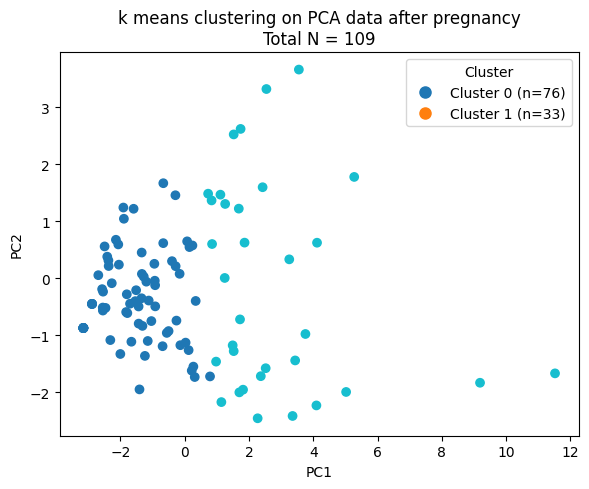

Cluster column 'before' not found – skipping.


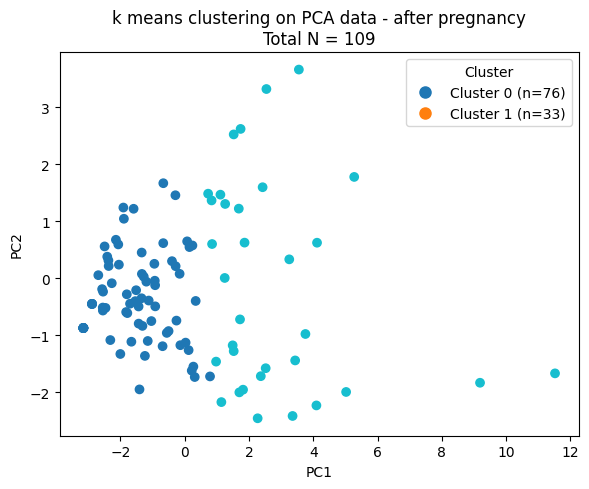

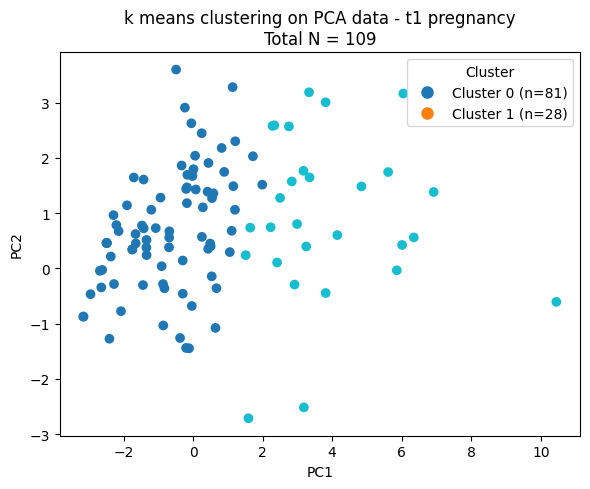

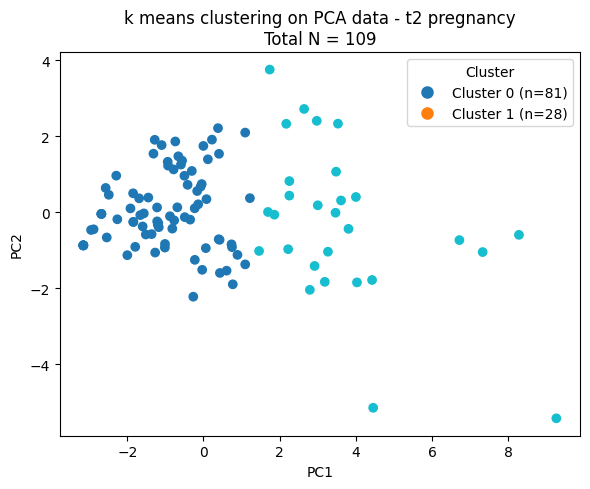

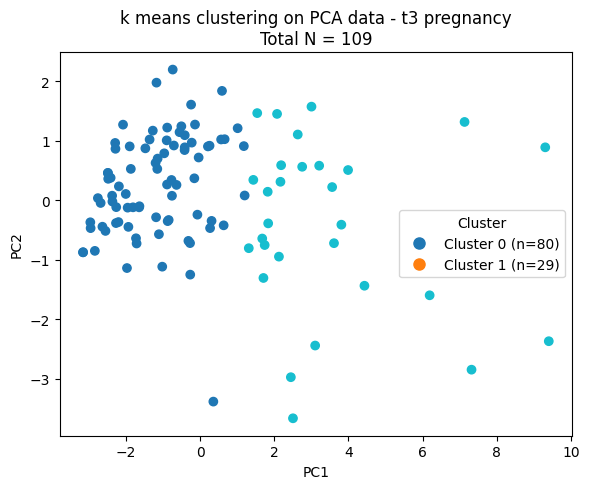

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Read the files
# -------------------------

pca_path = r"only_Q_outputs/combined/combined_pca_components.csv"
clusters_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"

pca_df = pd.read_csv(pca_path)
clusters_df = pd.read_csv(clusters_path)

# -------------------------
# 2. Helper: plot PCA for ONE timepoint
# -------------------------

def plot_pca_for_timepoint(
    pca_df,
    clusters_df,
    pca_timepoint,
    cluster_col_name,
    pc_x="PC1",
    pc_y="PC2",
    title=None,
    figsize=(6, 5)
):

    sub_pca = pca_df[pca_df["timepoint"] == pca_timepoint].copy()
    if sub_pca.empty:
        print(f"No PCA rows for timepoint '{pca_timepoint}' – skipping.")
        return

    if cluster_col_name not in clusters_df.columns:
        print(f"Cluster column '{cluster_col_name}' not found – skipping.")
        return

    clust_sub = clusters_df[["Subject_Code", cluster_col_name]].copy()
    clust_sub = clust_sub.dropna(subset=[cluster_col_name])

    merged = pd.merge(sub_pca, clust_sub, on="Subject_Code", how="inner")
    merged = merged.rename(columns={cluster_col_name: "Cluster"})

    if merged.empty:
        print(f"No overlap for timepoint '{pca_timepoint}'")
        return

    total_n = len(merged)

    plt.figure(figsize=figsize)
    scatter = plt.scatter(
        merged[pc_x],
        merged[pc_y],
        c=merged["Cluster"],
        cmap="tab10"
    )

    # --------------------------------------------------------
    # FIXED LEGEND: TRUE COUNTS PER CLUSTER
    # --------------------------------------------------------
    cluster_counts = merged["Cluster"].value_counts().sort_index()

    handles = []
    labels = []

    for cl in cluster_counts.index:
        color = plt.cm.tab10(cl % 10)

        handles.append(
            plt.Line2D([], [], marker='o', color=color, linestyle='', markersize=8)
        )
        labels.append(f"Cluster {cl} (n={cluster_counts[cl]})")

    plt.legend(handles, labels, title="Cluster")
    # --------------------------------------------------------

    if title is None:
        title = f"PCA clustering ({pca_timepoint}/{cluster_col_name})"

    plt.title(f"{title}\nTotal N = {total_n}")
    plt.xlabel(pc_x)
    plt.ylabel(pc_y)


    plt.tight_layout()
    plt.show()



# -------------------------
# 3. Examples of usage
# -------------------------

# "before pregnancy": PCA uses 'b', clusters file uses 'before'
plot_pca_for_timepoint(
    pca_df,
    clusters_df,
    pca_timepoint="b",
    cluster_col_name="before",
    pc_x="PC1",
    pc_y="PC2",
    title="k means clustering on PCA data before pregnancy (b/before)"
)

# "after pregnancy": both PCA and clusters use 'after'
plot_pca_for_timepoint(
    pca_df,
    clusters_df,
    pca_timepoint="after",
    cluster_col_name="after",
    pc_x="PC1",
    pc_y="PC2",
    title="k means clustering on PCA data after pregnancy"
)

# If later you have more mappings, you can loop:
timepoint_mapping = {
    "b": "before",
    "after": "after",
    "t1" :"t1",
    "t2":"t2",
    "t3":"t3"
    # "t1": "t1", etc...
}

for pca_tp, cluster_col in timepoint_mapping.items():
    plot_pca_for_timepoint(
        pca_df,
        clusters_df,
        pca_timepoint=pca_tp,
        cluster_col_name=cluster_col,
        pc_x="PC1",
        pc_y="PC2",
        title=f"k means clustering on PCA data - {cluster_col} pregnancy"
    )


# trajectories 

## plottign the trajectories for five subjects

Subjects with 5 timepoints: ['CT003', 'CT004', 'CT005', 'CT007', 'CT008', 'CT010', 'CT012', 'CT013', 'CT015', 'CT016', 'CT022', 'CT023', 'CT024', 'CT025', 'CT026', 'CT027', 'CT028', 'CT029', 'CT031', 'CT033', 'CT034', 'CT038', 'CT039', 'CT040', 'CT041', 'CT044', 'CT045', 'CT046', 'CT047', 'CT050', 'CT051', 'CT055', 'CT058', 'CT060', 'CT061', 'CT062', 'NT001', 'NT002', 'NT005', 'NT007', 'NT008', 'NT010', 'NT015', 'NT016', 'NT017', 'NT018', 'NT019', 'NT022', 'NT023', 'NT024', 'NT025', 'NT026', 'NT027', 'NT028', 'NT030', 'NT031', 'NT032', 'NT033', 'NT034', 'NT035', 'NT036', 'NT039', 'NT040', 'NT041', 'NT042', 'NT044', 'NT046', 'NT047', 'NT048', 'NT049', 'NT051', 'NT055', 'NT057', 'NT058', 'NT059', 'NT060', 'NT063', 'NT065', 'NT067', 'NT069', 'NT070', 'NT071', 'NT074', 'NT076', 'NT077', 'NT078', 'NT081', 'NT082', 'NT084', 'NT085', 'NT087', 'NT089', 'NT090', 'NT091', 'NT094', 'NT096', 'NT097', 'NT100', 'NT107', 'NT114', 'NT116', 'NT118', 'NT121', 'NT123', 'NT124', 'NT126', 'NT129', 'NT131',

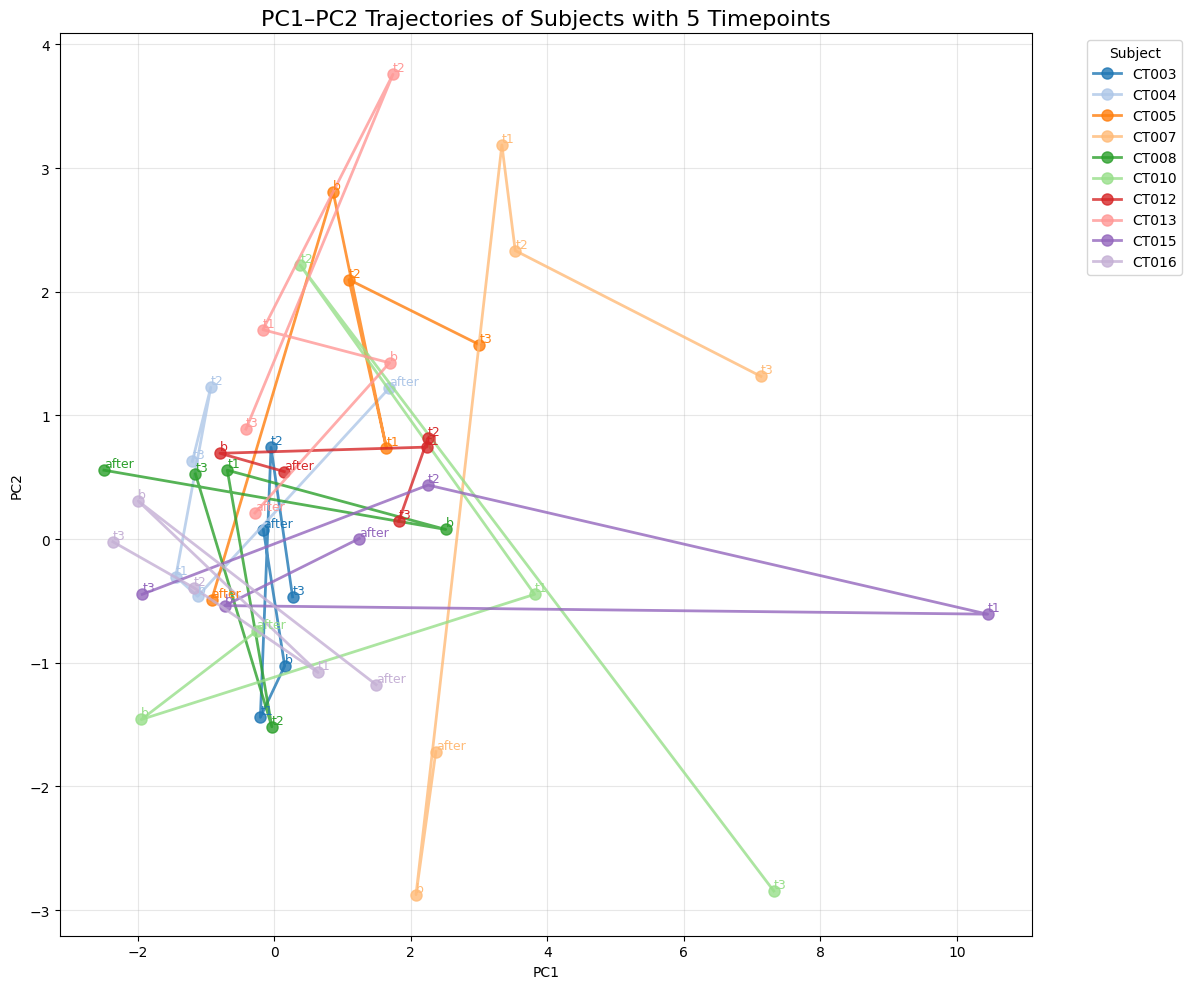

In [ ]:
df = pd.read_csv("only_Q_outputs/combined/combined_pca_components.csv")

subjects_with_5 = (
    df.groupby("Subject_Code")
      .size()
      .reset_index(name="count")
      .query("count == 5")["Subject_Code"]
      .tolist()
)

print("Subjects with 5 timepoints:", subjects_with_5)
import matplotlib.pyplot as plt
import pandas as pd

# Load
df = pd.read_csv("only_Q_outputs/combined/combined_pca_components.csv")

# Find subjects with 5 entries
subjects_with_5 = (
    df.groupby("Subject_Code")
      .size()
      .reset_index(name="count")
      .query("count == 5")["Subject_Code"]
      .tolist()
)

# Create a color palette
colors = plt.cm.tab20(range(len(subjects_with_5)))

plt.figure(figsize=(12, 10))

for col, subj in zip(colors, subjects_with_5[0:10]):

    # Filter and sort by timepoint
    sub_df = df[df["Subject_Code"] == subj].sort_values("timepoint")

    # PC1 vs PC2 line
    plt.plot(
        sub_df["PC1"], sub_df["PC2"],
        "-o", color=col, linewidth=2, markersize=8, alpha=0.8,
        label=subj
    )

    # Add timepoint labels next to each dot
    for _, row in sub_df.iterrows():
        plt.text(
            row["PC1"], row["PC2"],
            row["timepoint"],
            fontsize=9, ha="left", va="bottom", color=col
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1–PC2 Trajectories of Subjects with 5 Timepoints", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Subject")
plt.tight_layout()
plt.show()


# doing k means on the baseline parameters 

## 2 clusters 

Cluster relabeling mapping: {0: 0, 1: 1}


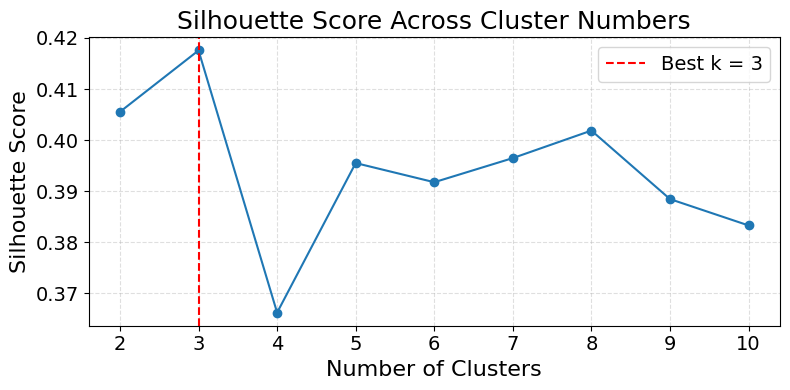

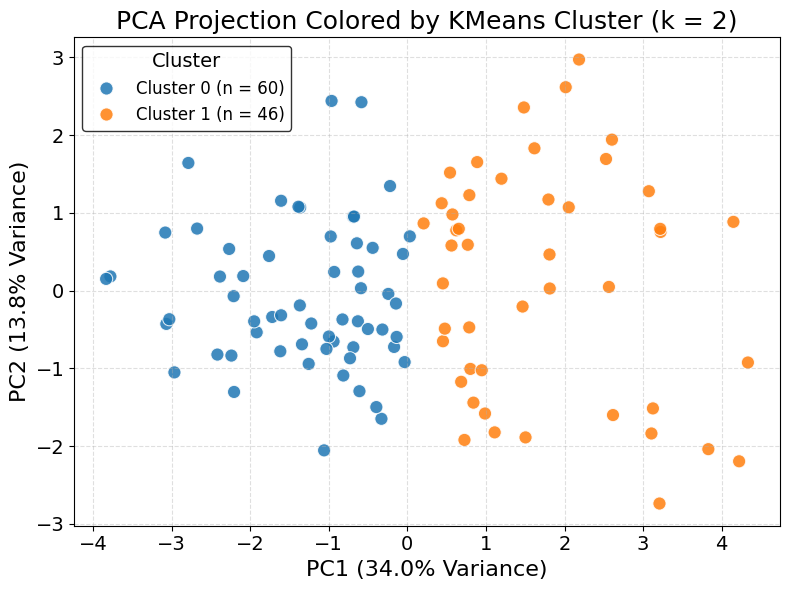

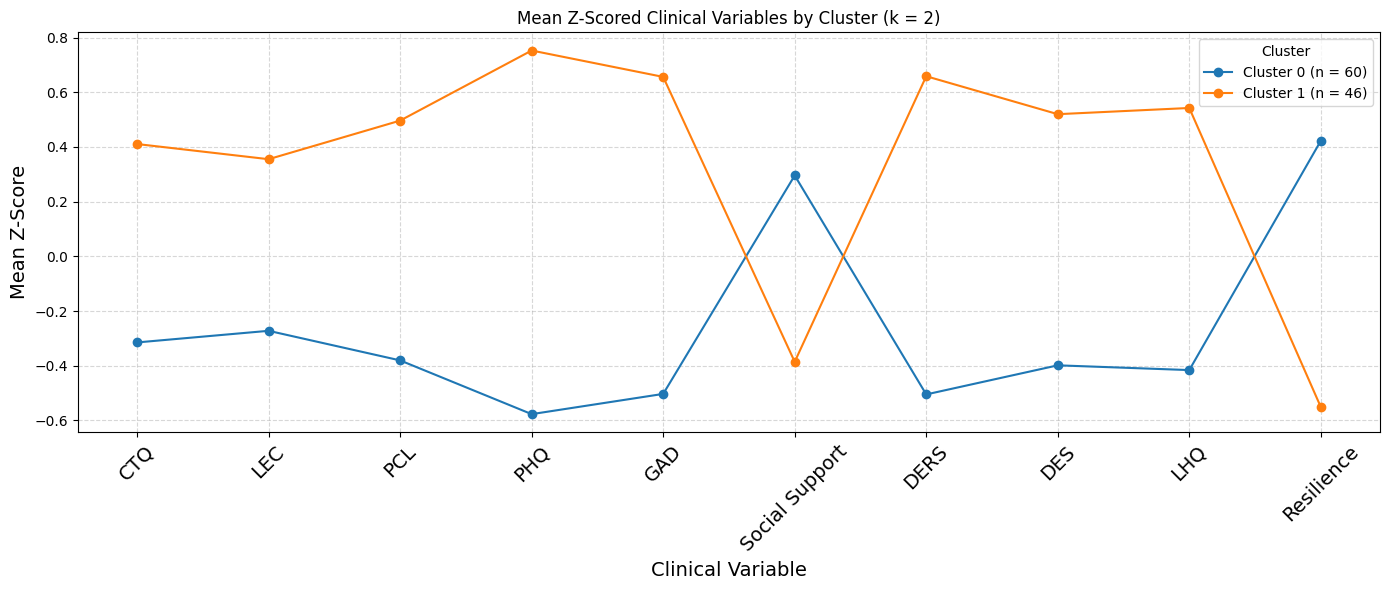

✅ Saved: only_Q_outputs\combined\subject_cluster_labels_k2.csv
Cluster
0    60
1    46
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

df = pd.read_csv(r"only_Q_outputs\combined\october_filtered_selected_columns_complete_subjects.csv")
rename_dict = {
    'b_ctq_total': 'CTQ',
    'b_lec_0_to_16_total': 'LEC',
    'b_pcl_total': 'PCL',
    'b_PHQ_total': 'PHQ',
    'b_GAD7_total': 'GAD',
    'b_social_support_total': 'Social Support',
    'b_DERS_total': 'DERS',
    'b_DES_average': 'DES',
    'b_LHQ_total': 'LHQ',
    'b_strength_average': 'Resilience'
}
# ============================================================
# 0. CONSISTENT CLUSTER COLOR PALETTE (for 2 clusters)
# ============================================================
cluster_palette = {
    0: "#1f77b4",   # blue
    1: "#ff7f0e",   # orange
}

# ============================================================
# 1. Clinical columns for PCA + KMeans
# ============================================================
measure_cols = [ 'b_ctq_total', 'b_lec_0_to_16_total',
'b_pcl_total', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total',
'b_DERS_total', 'b_DES_average', 'b_LHQ_total','b_strength_average']
cols_for_filter = measure_cols + ["Subject_Code"]

df_pca = df[cols_for_filter].dropna()

pca_data_clinical = df_pca[measure_cols]
subject_codes = df_pca["Subject_Code"].astype(str)

scaled_data = pca_data_clinical.apply(zscore)

# ============================================================
# 2. PCA
# ============================================================
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
explained_var = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(
    principal_components,
    columns=['PC1', 'PC2'],
    index=pca_data_clinical.index
)

# ============================================================
# 3. KMEANS WITH FIXED k = 2
# ============================================================
k = 2
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(principal_components)

# ============================================================
# 3b. REASSIGN CLUSTER LABELS SO CLUSTER WITH LOWEST PC1 = 0
# ============================================================
pca_df_temp = pd.DataFrame({
    'PC1': principal_components[:, 0],
    'Cluster': cluster_labels
})

cluster_pc1_means = pca_df_temp.groupby("Cluster")["PC1"].mean()
sorted_clusters = cluster_pc1_means.sort_values().index.tolist()
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}
print("Cluster relabeling mapping:", cluster_mapping)

cluster_labels_relab = np.array([cluster_mapping[c] for c in cluster_labels])
pca_df["Cluster"] = cluster_labels_relab

# ============================================================
# 4. Silhouette Score Plot (same as before: curve across k)
# ============================================================
range_n_clusters = list(range(2, 11))  # change 11 to whatever max-k you want
silhouette_scores = []

for kk in range_n_clusters:
    km = KMeans(n_clusters=kk, random_state=42, n_init=10)
    labels = km.fit_predict(principal_components)
    score = silhouette_score(principal_components, labels)
    silhouette_scores.append(score)

best_k = range_n_clusters[int(np.argmax(silhouette_scores))]

plt.figure(figsize=(8,4))
plt.plot(range_n_clusters, silhouette_scores, marker='o')

plt.axvline(best_k, color='red', linestyle='--',
            label=f"Best k = {best_k}")

plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)
plt.title("Silhouette Score Across Cluster Numbers", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()

# ============================================================
# 5. PCA SCATTER WITH CONSISTENT COLORS (k=2)
# ============================================================
plt.figure(figsize=(8, 6))

sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette=cluster_palette,
    hue_order=[0, 1],
    s=90,
    alpha=0.85
)

plt.title("PCA Projection Colored by KMeans Cluster (k = 2)", fontsize=18)
plt.xlabel(f"PC1 ({explained_var[0]:.1f}% Variance)", fontsize=16)
plt.ylabel(f"PC2 ({explained_var[1]:.1f}% Variance)", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)

cluster_sizes = pca_df["Cluster"].value_counts().sort_index()
legend_labels = [f"Cluster {i} (n = {cluster_sizes[i]})" for i in [0, 1]]

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=legend_labels,
    title="Cluster",
    title_fontsize=14,
    fontsize=12,
    loc="upper left",
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

plt.tight_layout()
plt.show()

# ============================================================
# 6. Z-SCORED CLUSTER MEANS ANALYSIS (k=2)
# ============================================================
clusters_z = pca_data_clinical.copy()
clusters_z = clusters_z.apply(zscore)
clusters_z["Cluster"] = cluster_labels_relab
clusters_z = clusters_z.dropna()

cluster_means_df = clusters_z.groupby("Cluster").mean().sort_index()
cluster_sizes = clusters_z["Cluster"].value_counts().sort_index()

# OPTIONAL: rename labels for plotting
rename_dict = {
    'b_ctq_total': 'CTQ',
    'b_lec_0_to_16_total': 'LEC',
    'b_pcl_total': 'PCL',
    'b_PHQ_total': 'PHQ',
    'b_GAD7_total': 'GAD',
    'b_social_support_total': 'Social Support',
    'b_DERS_total': 'DERS',
    'b_DES_average': 'DES',
    'b_LHQ_total': 'LHQ',
    'b_strength_average': 'Resilience'
}

cluster_means_df = cluster_means_df[measure_cols].rename(columns=rename_dict)

# ============================================================
# 7. FINAL PLOT: Mean Z-scored Clinical Profiles by Cluster (k=2)
# ============================================================
plt.figure(figsize=(14, 6))

for cluster_label, row in cluster_means_df.iterrows():
    color = cluster_palette.get(cluster_label)
    n = int(cluster_sizes.loc[cluster_label])
    plt.plot(
        cluster_means_df.columns,
        row.values,
        marker='o',
        label=f"Cluster {cluster_label} (n = {n})",
        color=color
    )

plt.title("Mean Z-Scored Clinical Variables by Cluster (k = 2)")
plt.xlabel("Clinical Variable", fontsize=14)
plt.ylabel("Mean Z-Score", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# ============================================================
# 9. Save Subject_Code + Cluster labels to CSV
# ============================================================
cluster_out = pd.DataFrame({
    "Subject_Code": subject_codes.values,
    "Cluster": cluster_labels_relab
})

# (optional) sort by cluster then subject
cluster_out = cluster_out.sort_values(["Cluster", "Subject_Code"]).reset_index(drop=True)

out_path = r"only_Q_outputs\combined\subject_cluster_labels_k2.csv"
cluster_out.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
print(cluster_out["Cluster"].value_counts().sort_index())


## 3 clusters 

Cluster relabeling mapping: {2: 0, 1: 1, 0: 2}


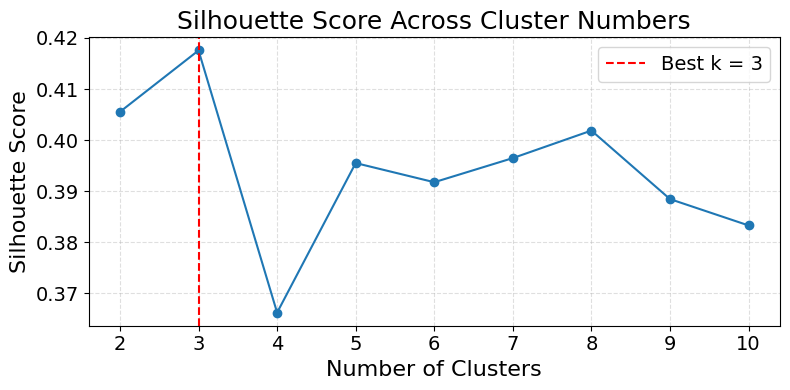

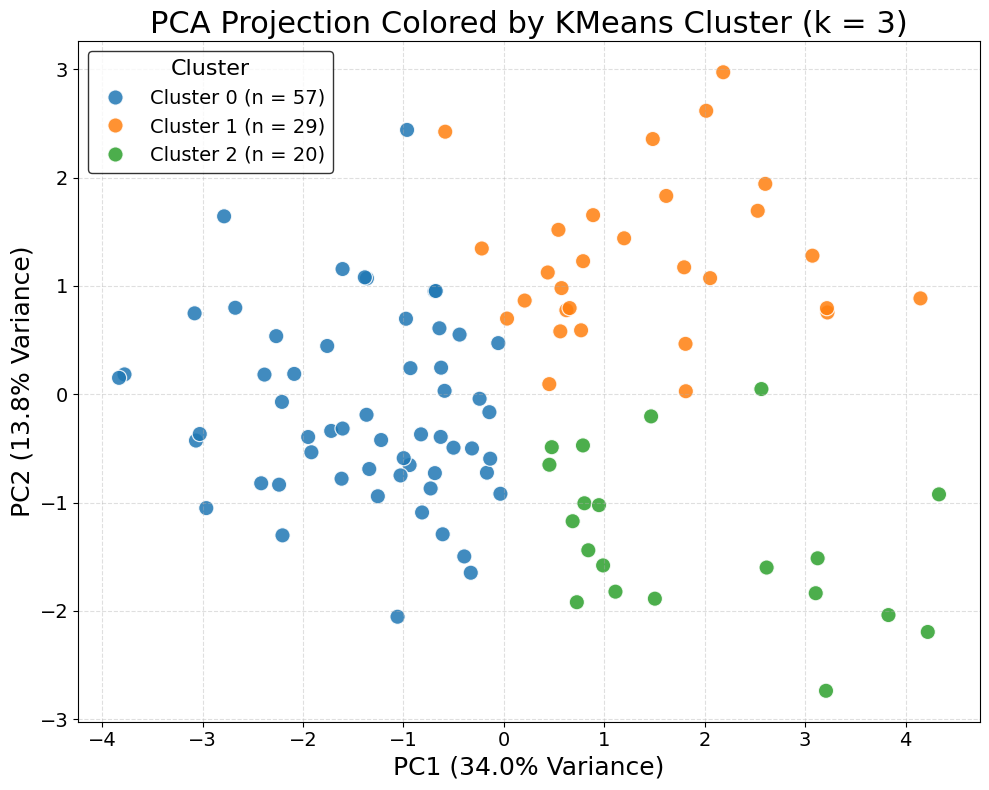

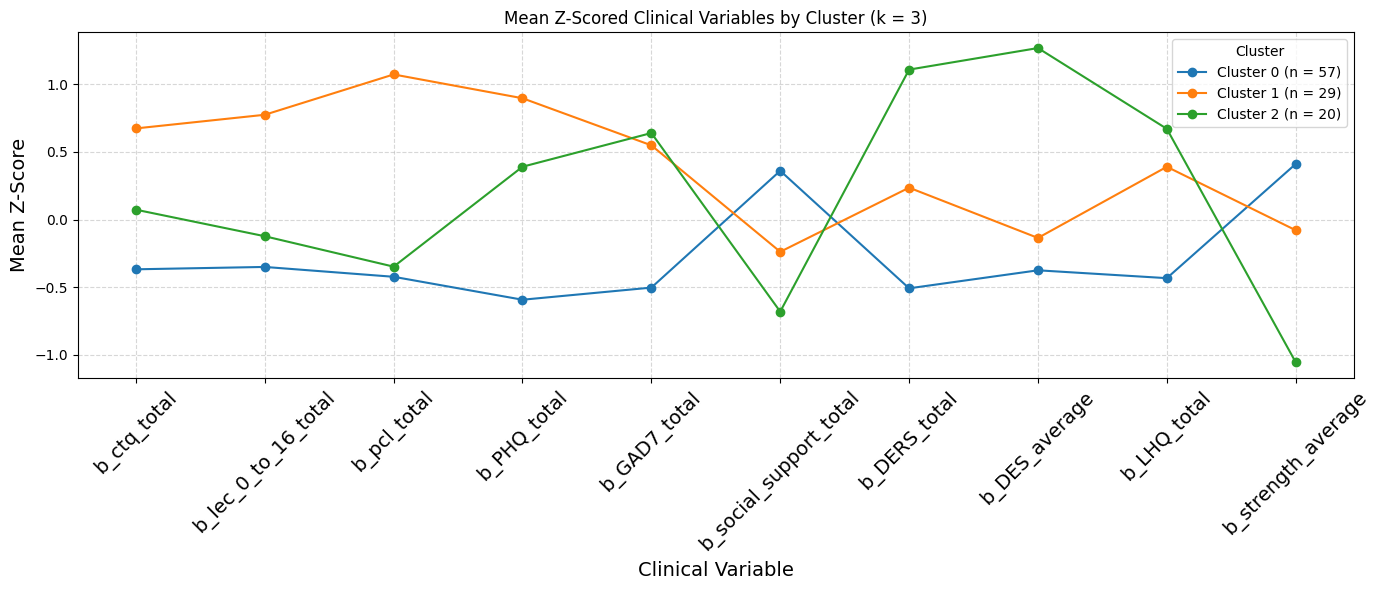

✅ Saved: only_Q_outputs\combined\subject_cluster_labels_k3.csv
Cluster
0    57
1    29
2    20
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.cluster import KMeans
df = pd.read_csv(r"only_Q_outputs\combined\october_filtered_selected_columns_complete_subjects.csv")

# ============================================================
# 0. CONSISTENT CLUSTER COLOR PALETTE (for 3 clusters)
# ============================================================
cluster_palette = {
    0: "#1f77b4",   # blue
    1: "#ff7f0e",   # orange
    2: "#2ca02c",   # green
}

# ============================================================
# 1. Clinical columns for PCA + KMeans
# ============================================================
measure_cols = [ 'b_ctq_total', 'b_lec_0_to_16_total',
 'b_pcl_total', 'b_PHQ_total', 'b_GAD7_total', 'b_social_support_total',
'b_DERS_total', 'b_DES_average', 'b_LHQ_total','b_strength_average']

# Include Subject_Code in the selection used to drop rows with missing data
cols_for_filter = measure_cols + ["Subject_Code"]

# Keep only complete rows across clinical variables + Subject_Code
df_pca = df[cols_for_filter].dropna()

# Clinical data only (for PCA & clustering)
pca_data_clinical = df_pca[measure_cols]

# Subject codes aligned with pca_data_clinical
subject_codes = df_pca["Subject_Code"]

# Z-score normalization of clinical data (not Subject_Code)
scaled_data = pca_data_clinical.apply(zscore)

# ============================================================
# 2. PCA
# ============================================================
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
explained_var = pca.explained_variance_ratio_ * 100

pca_df = pd.DataFrame(
    principal_components,
    columns=['PC1', 'PC2'],
    index=pca_data_clinical.index
)

# ============================================================
# 3. KMEANS WITH FIXED k = 3
# ============================================================
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(principal_components)  # original labels (0,1,2 but arbitrary)

# ============================================================
# 3b. REASSIGN CLUSTER LABELS SO CLUSTER WITH LOWEST PC1 = 0
# ============================================================
pca_df_temp = pd.DataFrame({
    'PC1': principal_components[:, 0],
    'Cluster': cluster_labels
})

# Compute mean PC1 for each original cluster
cluster_pc1_means = pca_df_temp.groupby("Cluster")["PC1"].mean()

# Sort clusters by PC1 mean (negative → positive)
sorted_clusters = cluster_pc1_means.sort_values().index.tolist()

# Create new mapping {old_label: new_label}
cluster_mapping = {old: new for new, old in enumerate(sorted_clusters)}
print("Cluster relabeling mapping:", cluster_mapping)

# Apply mapping to cluster_labels to get relabeled clusters
cluster_labels_relab = np.array([cluster_mapping[c] for c in cluster_labels])

# Add relabeled cluster labels to pca_df
pca_df["Cluster"] = cluster_labels_relab

# ============================================================
# 4. Silhouette Score Plot — with bigger fonts
# ============================================================
plt.figure(figsize=(8,4))
plt.plot(list(range_n_clusters), silhouette_scores, marker='o')

plt.axvline(best_k, color='red', linestyle='--',
            label=f"Best k = {best_k}")

plt.xlabel("Number of Clusters", fontsize=16)
plt.ylabel("Silhouette Score", fontsize=16)
plt.title("Silhouette Score Across Cluster Numbers", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()



# ============================================================
# PCA SCATTER WITH CONSISTENT COLORS + SUBJECT NUMBERS INSIDE PLOT
# ============================================================

plt.figure(figsize=(10, 8))

# Scatterplot
sns.scatterplot(
    data=pca_df,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette=cluster_palette,
    hue_order=[0, 1, 2],
    s=120,                     # bigger points
    alpha=0.85
)



# ------------------------------------------
# Build legend labels including cluster size
# ------------------------------------------
cluster_sizes = pca_df["Cluster"].value_counts().sort_index()
legend_labels = [f"Cluster {i} (n = {cluster_sizes[i]})" for i in [0, 1, 2]]

handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(
    handles=handles,
    labels=legend_labels,
    title="Cluster",
    title_fontsize=16,
    fontsize=14,
    loc="upper left",           # stays *inside* the plot
    frameon=True,
    facecolor="white",
    edgecolor="black"
)

# ------------------------------------------
# Labels & Formatting
# ------------------------------------------
plt.title("PCA Projection Colored by KMeans Cluster (k = 3)", fontsize=22)
plt.xlabel(f"PC1 ({explained_var[0]:.1f}% Variance)", fontsize=18)
plt.ylabel(f"PC2 ({explained_var[1]:.1f}% Variance)", fontsize=18)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


# ============================================================
# 5. Z-SCORED CLUSTER MEANS ANALYSIS
# ============================================================
# Build a dataframe with clinical variables + relabeled KMeans cluster
clusters_z = pca_data_clinical.copy()
clusters_z = clusters_z.apply(zscore)          # z-score clinical values
clusters_z["Cluster"] = cluster_labels_relab   # attach *relabelled* cluster labels
clusters_z = clusters_z.dropna()

# Compute cluster means, sorted so 0,1,2 (cluster 0 always "leftmost" on PC1)
cluster_means_df = clusters_z.groupby("Cluster").mean().sort_index()

# ============================================================
# 6. CLEAN COLUMN ORDERING + RENAMING
# ============================================================
desired_order =  [ "CTQ","LEC","PCL","PHQ","GAD","Social Support","DERS","DES","LHQ","Resilience"]

cluster_means_df = cluster_means_df[measure_cols]


# Count subjects per cluster (also sorted 0,1,2)
cluster_sizes = clusters_z["Cluster"].value_counts().sort_index()

# ============================================================
# 7. FINAL PLOT: Mean Z-scored Clinical Profiles by Cluster
# ============================================================
plt.figure(figsize=(14, 6))

for cluster_label, row in cluster_means_df.iterrows():
    color = cluster_palette.get(cluster_label)
    n = int(cluster_sizes.loc[cluster_label])
    plt.plot(
        cluster_means_df.columns,
        row.values,
        marker='o',
        label=f"Cluster {cluster_label} (n = {n})",
        color=color
    )

plt.title("Mean Z-Scored Clinical Variables by Cluster (k = 3)")
plt.xlabel("Clinical Variable",fontsize = 14)
plt.ylabel("Mean Z-Score",fontsize = 14)
plt.xticks(rotation=45,fontsize = 14)
plt.legend(title="Cluster")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


 
    
    
# ============================================================
# SAVE Subject_Code + Cluster (k = 3)
# ============================================================
cluster_out = pd.DataFrame({
    "Subject_Code": subject_codes.astype(str).values,
    "Cluster": cluster_labels_relab
})

cluster_out = cluster_out.sort_values(["Cluster", "Subject_Code"]).reset_index(drop=True)

out_path = r"only_Q_outputs\combined\subject_cluster_labels_k3.csv"
cluster_out.to_csv(out_path, index=False)

print("✅ Saved:", out_path)
print(cluster_out["Cluster"].value_counts().sort_index())


## creatig a file of the subjects + thier position in comparison to the seprators +  the label we gor from the k means on 2 clusters 

In [ ]:
import pandas as pd
from pathlib import Path

# =========================
# Paths
# =========================
binary_path = r"only_Q_outputs\combined\subject_all_timepoints_pc1_3class_with_cluster.csv"
pca_path    = r"only_Q_outputs\combined\combined_pca_components.csv"

out_healthy = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
out_clin    = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"
out_symp_good    = r"only_Q_outputs\combined\symp_good_clinincal_subjects_pca.csv"

subject_col = "Subject_Code"

# =========================
# Load files
# =========================
bin_df = pd.read_csv(binary_path)
pca_df = pd.read_csv(pca_path)

# Clean Subject_Code
bin_df[subject_col] = bin_df[subject_col].astype(str).str.strip()
pca_df[subject_col] = pca_df[subject_col].astype(str).str.strip()

# Make sure needed columns are numeric
bin_df["Cluster"] = pd.to_numeric(bin_df["Cluster"], errors="coerce")
# =========================
# Select subject sets (SAME condition for both)
# =========================
selected_subjects_clinical  = set(
    bin_df.loc[(bin_df["Cluster"] == 1) & (bin_df["b"] == 1) & (bin_df["t1"] == 1) & (bin_df["t2"] == 1) & (bin_df["t3"] == 1) & (bin_df["after"] == 1), subject_col]
)
selected_subjects_healthy  = set(
    bin_df.loc[(bin_df["Cluster"] == 0) & (bin_df["b"] == 0)& (bin_df["t1"] == 0)& (bin_df["t2"] == 0)& (bin_df["t3"] == 0)& (bin_df["after"] == 0), subject_col]
)
selected_subjects_symp_good = set(
    bin_df.loc[(bin_df["Cluster"] == 1) & (bin_df["b"] == 0) ,subject_col]
)
healthy_subjects = selected_subjects_healthy
clinical_subjects = selected_subjects_clinical
symp_good = selected_subjects_symp_good
print("Selected subjects (Cluster=1 & b=1):", len(selected_subjects_clinical))
print("Selected subjects (Cluster=0 & b=0):", len(selected_subjects_healthy))
print("Selected subjects (Cluster=1 & b=0):", len(selected_subjects_symp_good))



# =========================
# Filter PCA rows for those subjects (all timepoints)
# =========================
healthy_pca = pca_df[pca_df[subject_col].isin(healthy_subjects)].copy()
clinical_pca = pca_df[pca_df[subject_col].isin(clinical_subjects)].copy()
symp_good_pca = pca_df[pca_df[subject_col].isin(symp_good)].copy()

# =========================
# Save
# =========================
Path(out_healthy).parent.mkdir(parents=True, exist_ok=True)

healthy_pca.to_csv(out_healthy, index=False)
clinical_pca.to_csv(out_clin, index=False)
symp_good_pca.to_csv(out_symp_good, index=False)

print("✅ Saved:", out_healthy, "| rows:", len(healthy_pca))
print("✅ Saved:", out_clin, "| rows:", len(clinical_pca))


Selected subjects (Cluster=1 & b=1): 4
Selected subjects (Cluster=0 & b=0): 22
Selected subjects (Cluster=1 & b=0): 14
✅ Saved: only_Q_outputs\combined\start_healthy_subjects_pca.csv | rows: 110
✅ Saved: only_Q_outputs\combined\start_clinincal_subjects_pca.csv | rows: 20


# analsyis of the trajectory+ baseline clusters 

## creating file with the good subjects and the bad subjects in the base line  trajectory 

In [ ]:
import pandas as pd
from pathlib import Path

# =========================
# Paths
# =========================
binary_path = r"only_Q_outputs\combined\subject_all_timepoints_pc1_3class_with_cluster.csv"
pca_path    = r"only_Q_outputs\combined\combined_pca_components.csv"

out_healthy = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
out_clin    = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"
out_symp_good    = r"only_Q_outputs\combined\symp_good_clinincal_subjects_pca.csv"

subject_col = "Subject_Code"

# =========================
# Load files
# =========================
bin_df = pd.read_csv(binary_path)
pca_df = pd.read_csv(pca_path)

# Clean Subject_Code
bin_df[subject_col] = bin_df[subject_col].astype(str).str.strip()
pca_df[subject_col] = pca_df[subject_col].astype(str).str.strip()

# Make sure needed columns are numeric
bin_df["Cluster"] = pd.to_numeric(bin_df["Cluster"], errors="coerce")
# =========================
# Select subject sets (SAME condition for both)
# =========================
selected_subjects_clinical  = set(
    bin_df.loc[(bin_df["Cluster"] == 1) & (bin_df["b"] == 1) & (bin_df["t1"] == 1) & (bin_df["t2"] == 1) & (bin_df["t3"] == 1) & (bin_df["after"] == 1), subject_col]
)
selected_subjects_healthy  = set(
    bin_df.loc[(bin_df["Cluster"] == 0) & (bin_df["b"] == 0)& (bin_df["t1"] == 0)& (bin_df["t2"] == 0)& (bin_df["t3"] == 0)& (bin_df["after"] == 0), subject_col]
)
selected_subjects_symp_good = set(
    bin_df.loc[(bin_df["Cluster"] == 1) & (bin_df["b"] == 0) ,subject_col]
)
healthy_subjects = selected_subjects_healthy
clinical_subjects = selected_subjects_clinical
symp_good = selected_subjects_symp_good
print("Selected subjects (Cluster=1 & b=1):", len(selected_subjects_clinical))
print("Selected subjects (Cluster=0 & b=0):", len(selected_subjects_healthy))
print("Selected subjects (Cluster=1 & b=0):", len(selected_subjects_symp_good))



# =========================
# Filter PCA rows for those subjects (all timepoints)
# =========================
healthy_pca = pca_df[pca_df[subject_col].isin(healthy_subjects)].copy()
clinical_pca = pca_df[pca_df[subject_col].isin(clinical_subjects)].copy()
symp_good_pca = pca_df[pca_df[subject_col].isin(symp_good)].copy()

# =========================
# Save
# =========================
Path(out_healthy).parent.mkdir(parents=True, exist_ok=True)

healthy_pca.to_csv(out_healthy, index=False)
clinical_pca.to_csv(out_clin, index=False)
symp_good_pca.to_csv(out_symp_good, index=False)

print("✅ Saved:", out_healthy, "| rows:", len(healthy_pca))
print("✅ Saved:", out_clin, "| rows:", len(clinical_pca))


Selected subjects (Cluster=1 & b=1): 4
Selected subjects (Cluster=0 & b=0): 22
Selected subjects (Cluster=1 & b=0): 14
✅ Saved: only_Q_outputs\combined\start_healthy_subjects_pca.csv | rows: 110
✅ Saved: only_Q_outputs\combined\start_clinincal_subjects_pca.csv | rows: 20


## plotting the subjects in each group

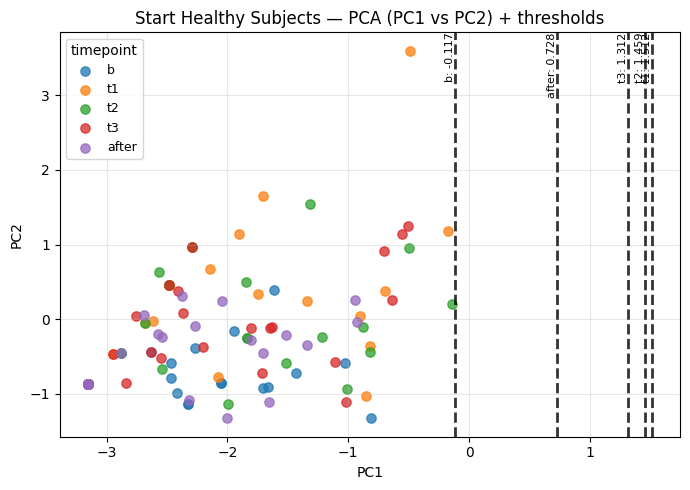

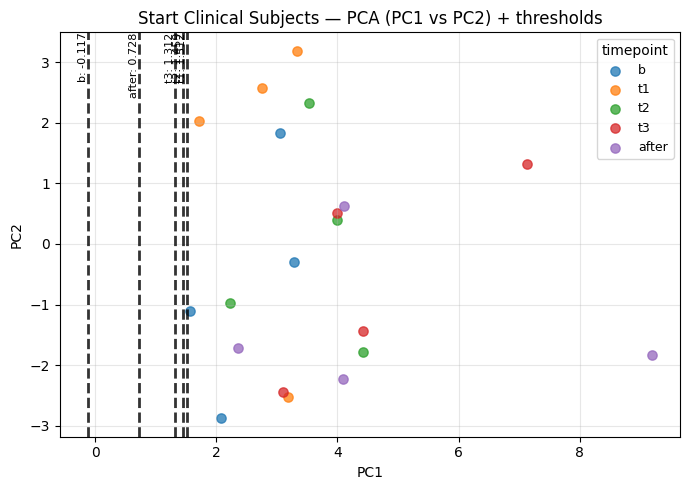

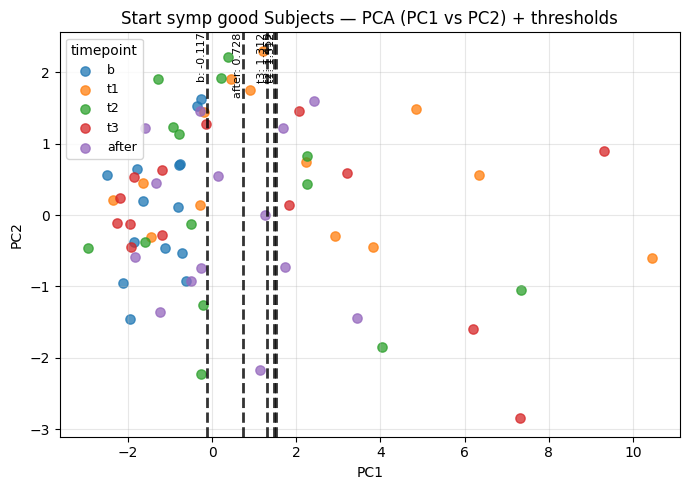

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
healthy_path   = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
clinical_path  = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"
symp_good_path = r"only_Q_outputs\combined\symp_good_clinincal_subjects_pca.csv"
separators_path = r"only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv"

# If your columns differ, update these:
pc1_col = "PC1"
pc2_col = "PC2"
tp_col  = "timepoint"

timepoint_order = ["b", "t1", "t2", "t3", "after"]

# =========================
# Load
# =========================
healthy_df = pd.read_csv(healthy_path)
clinical_df = pd.read_csv(clinical_path)
sep_df = pd.read_csv(separators_path)   # columns: timepoint, PC1_separator
symp_good_df = pd.read_csv(symp_good_path)
# Clean timepoint ordering (optional)
if tp_col in sep_df.columns:
    sep_df[tp_col] = sep_df[tp_col].astype(str).str.strip()
    sep_df[tp_col] = pd.Categorical(sep_df[tp_col], categories=timepoint_order, ordered=True)
    sep_df = sep_df.sort_values(tp_col)

def plot_group(df, title):
    df = df.copy()

    # Ensure timepoint exists + clean it
    if tp_col in df.columns:
        df[tp_col] = df[tp_col].astype(str).str.strip()
        df[tp_col] = pd.Categorical(df[tp_col], categories=timepoint_order, ordered=True)

    plt.figure(figsize=(7, 5))

    # ---- Scatter ----
    if tp_col in df.columns:
        # color by timepoint
        for tp in timepoint_order:
            sub = df[df[tp_col] == tp]
            if len(sub) == 0:
                continue
            plt.scatter(sub[pc1_col], sub[pc2_col], s=45, alpha=0.75, label=str(tp))
        plt.legend(title="timepoint", loc="best", fontsize=9)
    else:
        # single color
        plt.scatter(df[pc1_col], df[pc2_col], s=45, alpha=0.75)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.grid(alpha=0.3)

    # ---- Add thresholds (vertical lines) ----
    y_min, y_max = plt.ylim()

    for _, row in sep_df.iterrows():
        tp = str(row[tp_col])
        x = float(row["PC1_separator"])

        plt.axvline(x, linestyle="--", linewidth=2, color="black", alpha=0.8)
        plt.text(
            x, y_max,
            f"{tp}: {x:.3f}",
            rotation=90,
            va="top",
            ha="right",
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

# =========================
# Plot both groups
# =========================
plot_group(healthy_df, "Start Healthy Subjects — PCA (PC1 vs PC2) + thresholds")
plot_group(clinical_df, "Start Clinical Subjects — PCA (PC1 vs PC2) + thresholds")
plot_group(symp_good_df,"Start symp good Subjects — PCA (PC1 vs PC2) + thresholds")

## plotting the trajectory in each group

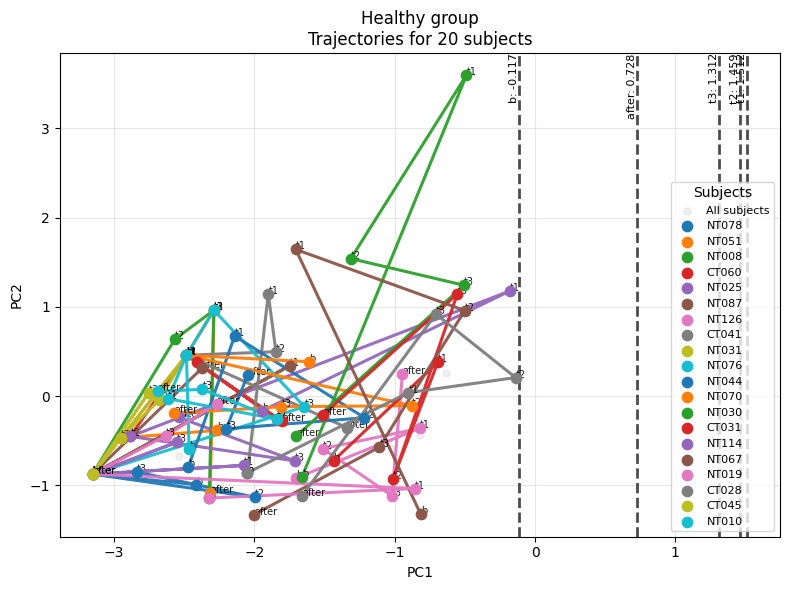

Healthy group: plotted subjects:
['NT078', 'NT051', 'NT008', 'CT060', 'NT025', 'NT087', 'NT126', 'CT041', 'NT031', 'NT076', 'NT044', 'NT070', 'NT030', 'CT031', 'NT114', 'NT067', 'NT019', 'CT028', 'CT045', 'NT010']


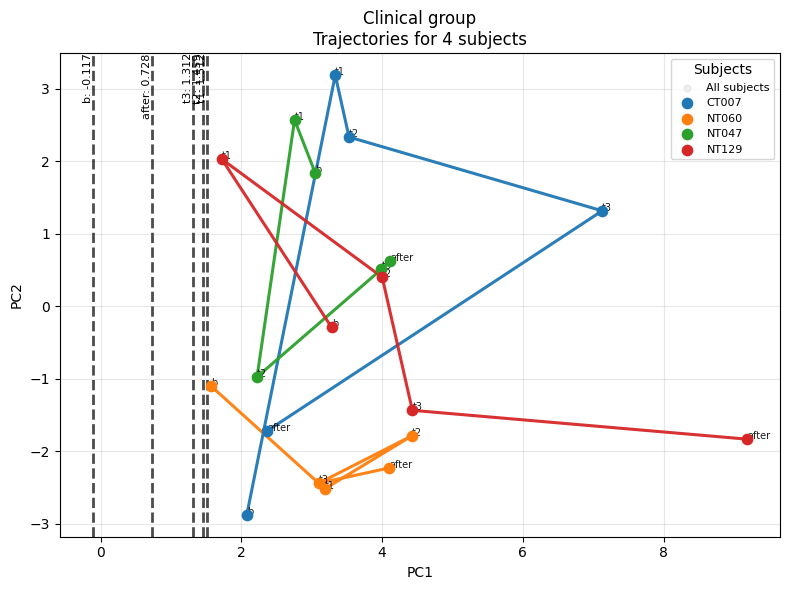

Clinical group: plotted subjects:
['CT007', 'NT060', 'NT047', 'NT129']


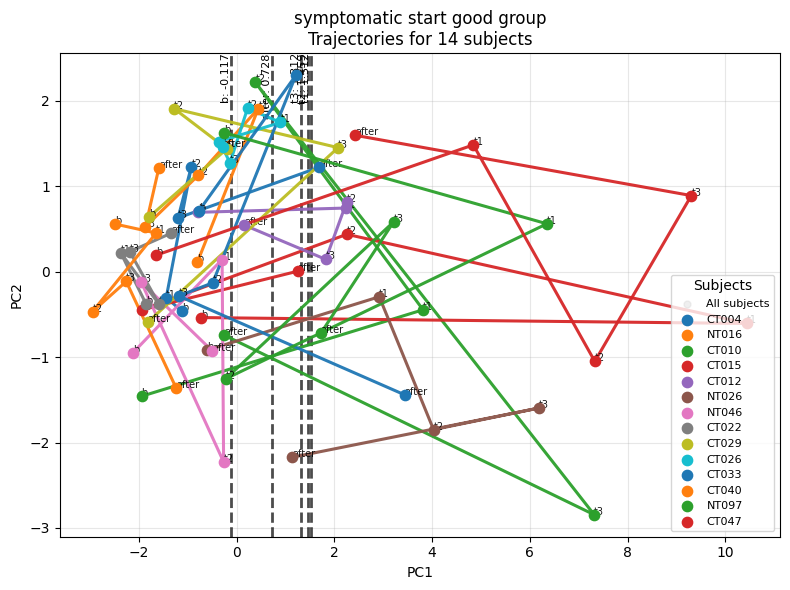

symptomatic start good group: plotted subjects:
['CT004', 'NT016', 'CT010', 'CT015', 'CT012', 'NT026', 'NT046', 'CT022', 'CT029', 'CT026', 'CT033', 'CT040', 'NT097', 'CT047']


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# =========================
# Paths
# =========================
healthy_path    = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
clinical_path   = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"
separators_path = r"only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv"
symp_good_path = r"only_Q_outputs\combined\symp_good_clinincal_subjects_pca.csv"
subject_col = "Subject_Code"
pc1_col = "PC1"
pc2_col = "PC2"
tp_col  = "timepoint"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# pick 10 subjects per file
N_SUBJECTS = 20
RANDOM_SEED = 0  # change for different samples (or set None)

# =========================
# Load
# =========================
healthy_df  = pd.read_csv(healthy_path)
clinical_df = pd.read_csv(clinical_path)
sep_df      = pd.read_csv(separators_path)  # columns: timepoint, PC1_separator
symp_good_df = pd.read_csv(symp_good_path)
# Clean separators order
sep_df[tp_col] = sep_df[tp_col].astype(str).str.strip()
sep_df[tp_col] = pd.Categorical(sep_df[tp_col], categories=timepoint_order, ordered=True)
sep_df = sep_df.sort_values(tp_col)

def plot_group_with_trajectories(df, title):
    df = df.copy()

    # clean
    df[subject_col] = df[subject_col].astype(str).str.strip()
    df[tp_col] = df[tp_col].astype(str).str.strip()
    df[tp_col] = pd.Categorical(df[tp_col], categories=timepoint_order, ordered=True)

    # choose 10 subjects
    subjects = df[subject_col].dropna().unique()
    if len(subjects) == 0:
        print(f"No subjects found for {title}")
        return

    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()
    chosen = subjects if len(subjects) <= N_SUBJECTS else rng.choice(subjects, size=N_SUBJECTS, replace=False)

    # assign colors
    colors = {subj: cm.tab10(i % 10) for i, subj in enumerate(chosen)}

    plt.figure(figsize=(8, 6))

    # ---- background scatter (all points) ----
    plt.scatter(df[pc1_col], df[pc2_col], color="lightgray", alpha=0.35, s=25, label="All subjects")

    # ---- thresholds ----
    y_min, y_max = plt.ylim()
    for _, row in sep_df.iterrows():
        tp = str(row[tp_col])
        x = float(row["PC1_separator"])
        plt.axvline(x, linestyle="--", linewidth=2, color="black", alpha=0.7)
        plt.text(x, y_max, f"{tp}: {x:.3f}", rotation=90, va="top", ha="right", fontsize=8)

    # ---- trajectories for chosen subjects ----
    for subj in chosen:
        dsub = df[df[subject_col] == subj].copy().sort_values(tp_col)

        # keep only valid timepoints and drop missing PC values
        dsub = dsub[dsub[tp_col].isin(timepoint_order)].dropna(subset=[pc1_col, pc2_col])

        if len(dsub) < 2:
            continue

        c = colors[subj]

        # line
        plt.plot(dsub[pc1_col], dsub[pc2_col], linewidth=2.2, alpha=0.95, color=c, zorder=3)

        # points
        plt.scatter(dsub[pc1_col], dsub[pc2_col], s=55, color=c, zorder=4, label=f"{subj}")

        # optional: annotate each point by timepoint
        for _, r in dsub.iterrows():
            plt.text(r[pc1_col], r[pc2_col], str(r[tp_col]), fontsize=7, alpha=0.9)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"{title}\nTrajectories for {min(N_SUBJECTS, len(subjects))} subjects")
    plt.grid(alpha=0.3)

    # keep legend readable (many labels): show only chosen subjects + "All subjects"
    plt.legend(loc="best", fontsize=8, title="Subjects", ncol=1)
    plt.tight_layout()
    plt.show()

    print(f"{title}: plotted subjects:")
    print(list(chosen))

# =========================
# Plot both groups
# =========================
plot_group_with_trajectories(healthy_df,  "Healthy group")
plot_group_with_trajectories(clinical_df, "Clinical group")
plot_group_with_trajectories(symp_good_pca, "symptomatic start good group")


Subjects with 5 timepoints AND cluster change: ['CT003', 'CT004', 'CT005', 'CT008', 'CT010', 'CT012', 'CT013', 'CT015', 'CT016', 'CT023', 'CT024', 'CT025', 'CT027', 'CT029', 'CT033', 'CT034', 'CT038', 'CT044', 'CT046', 'CT047', 'CT051', 'CT058', 'CT061', 'CT062', 'NT002', 'NT007', 'NT015', 'NT018', 'NT022', 'NT023', 'NT024', 'NT026', 'NT028', 'NT033', 'NT034', 'NT035', 'NT036', 'NT040', 'NT048', 'NT049', 'NT055', 'NT057', 'NT058', 'NT063', 'NT069', 'NT074', 'NT077', 'NT081', 'NT082', 'NT089', 'NT090', 'NT094', 'NT097', 'NT100', 'NT116', 'NT118', 'NT121', 'NT124', 'NT129', 'NT131', 'NT136']


C:\Users\nogag\AppData\Local\Temp\ipykernel_16812\1170473326.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(subjects_to_plot), 1))


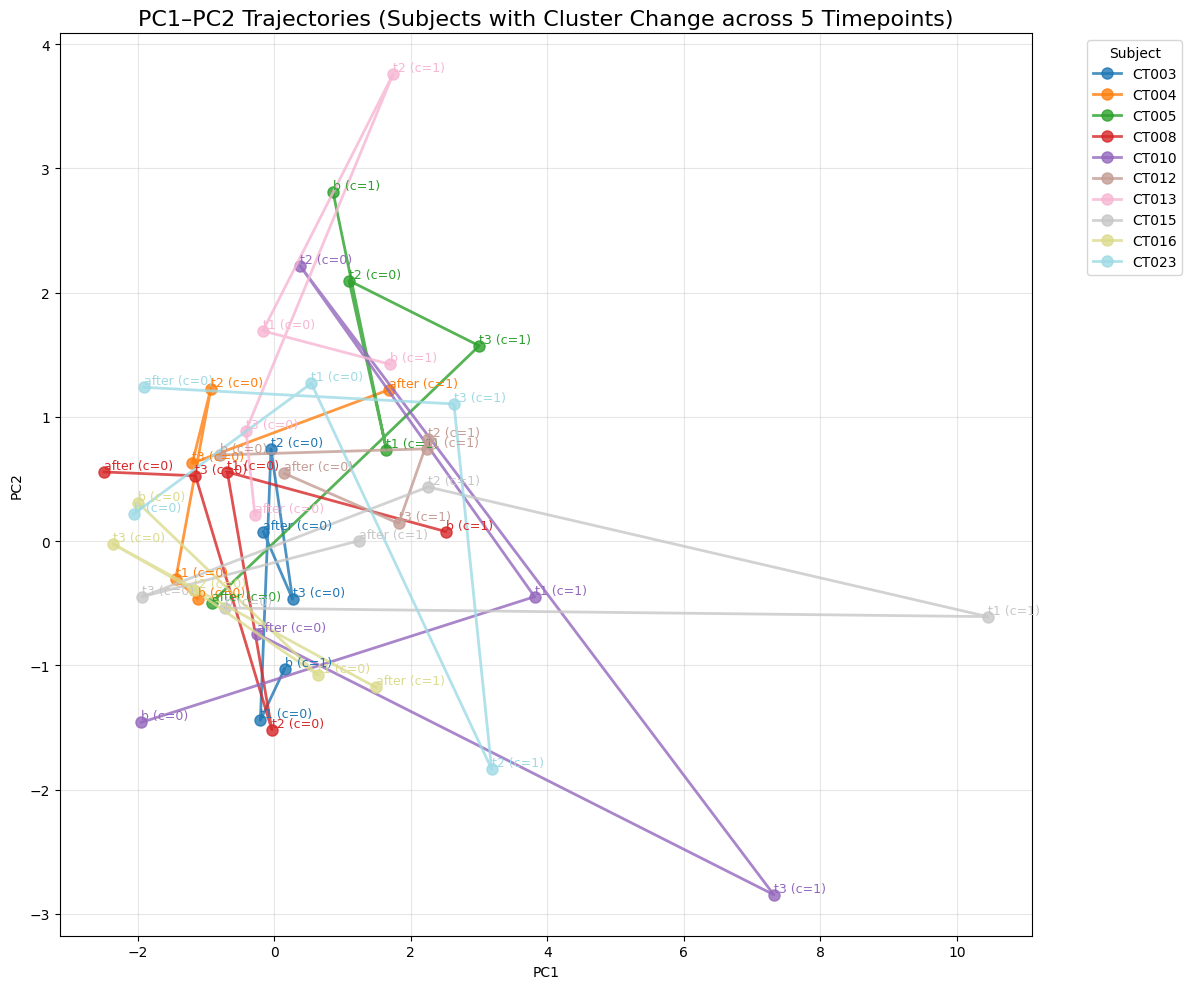

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ---------- Paths ----------
pca_path = r"only_Q_outputs/combined/combined_pca_components.csv"
cluster_path = r"only_Q_outputs/combined/timepoints_file_inverted_2.csv"  # <-- your inverted file

# ---------- Load PCA data ----------
df = pd.read_csv(pca_path)

subject_col = "Subject_Code"
time_col = "timepoint"

# ---------- Load cluster (inverted) file and convert to long format ----------
cl = pd.read_csv(cluster_path)

# cl is wide: Subject_Code | b | t1 | t2 | t3 | after
# melt -> long: Subject_Code | timepoint | cluster
cl_long = cl.melt(
    id_vars=[subject_col],
    var_name=time_col,
    value_name="cluster"
)

# Optional: make sure cluster is numeric (if your file stores "0"/"1" as strings)
cl_long["cluster"] = pd.to_numeric(cl_long["cluster"], errors="coerce")

# ---------- Merge clusters into PCA df ----------
dfm = df.merge(cl_long, on=[subject_col, time_col], how="inner")

# ---------- Keep only subjects with exactly 5 timepoints ----------
subjects_with_5 = (
    dfm.groupby(subject_col)
       .size()
       .reset_index(name="count")
       .query("count == 5")[subject_col]
       .tolist()
)
df5 = dfm[dfm[subject_col].isin(subjects_with_5)].copy()

# ---------- Sort timepoints ----------
tp_order = ["b", "t1", "t2", "t3", "after"]
if set(df5[time_col].astype(str)).issubset(set(tp_order)):
    df5[time_col] = pd.Categorical(df5[time_col].astype(str), categories=tp_order, ordered=True)

df5 = df5.sort_values([subject_col, time_col])

# ---------- Subjects with at least one cluster change ----------
subjects_with_cluster_change = (
    df5.groupby(subject_col)["cluster"]
       .apply(lambda s: s.nunique(dropna=True) > 1)
)
subjects_with_cluster_change = subjects_with_cluster_change[subjects_with_cluster_change].index.tolist()

print("Subjects with 5 timepoints AND cluster change:", subjects_with_cluster_change)

# ---------- Plot ----------
N = 10  # set None to plot all
subjects_to_plot = subjects_with_cluster_change if N is None else subjects_with_cluster_change[:N]

cmap = plt.cm.get_cmap("tab20", max(len(subjects_to_plot), 1))
plt.figure(figsize=(12, 10))

for i, subj in enumerate(subjects_to_plot):
    sub_df = df5[df5[subject_col] == subj].sort_values(time_col)

    plt.plot(
        sub_df["PC1"], sub_df["PC2"],
        "-o", color=cmap(i), linewidth=2, markersize=8, alpha=0.8,
        label=subj
    )

    # Label each point with timepoint + cluster
    for _, row in sub_df.iterrows():
        plt.text(
            row["PC1"], row["PC2"],
            f'{row[time_col]} (c={int(row["cluster"]) if pd.notna(row["cluster"]) else "NA"})',
            fontsize=9, ha="left", va="bottom", color=cmap(i)
        )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1–PC2 Trajectories (Subjects with Cluster Change across 5 Timepoints)", fontsize=16)
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Subject")
plt.tight_layout()
plt.show()


## plotting the trajectory for the two cinical and healthy groups

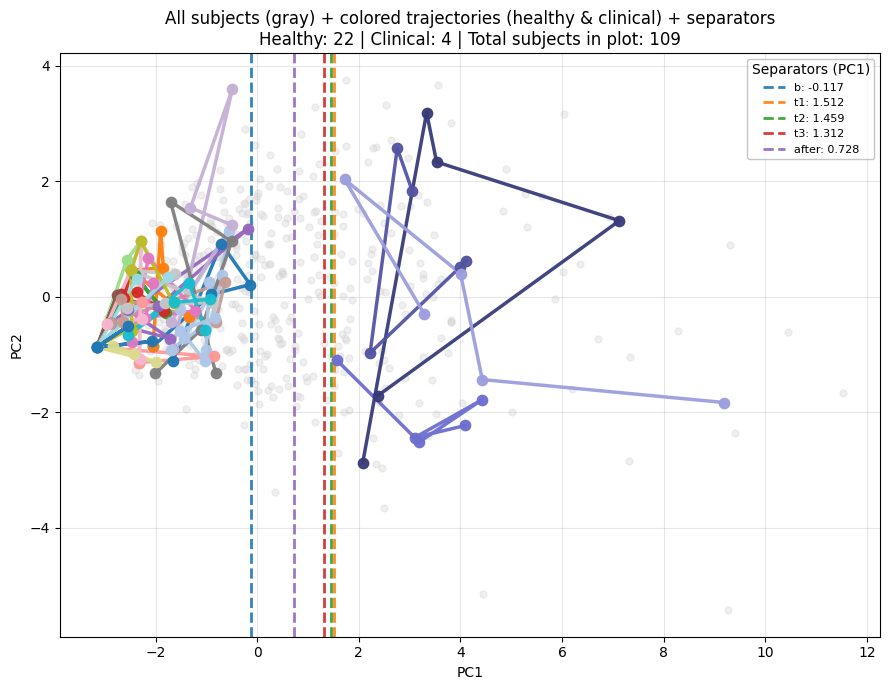

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Paths
# =========================
pca_path       = r"only_Q_outputs\combined\combined_pca_components.csv"
healthy_path   = r"only_Q_outputs\combined\start_healthy_subjects_pca.csv"
clinical_path  = r"only_Q_outputs\combined\start_clinincal_subjects_pca.csv"

# separators file (the one you already created)
sep_path       = r"only_Q_outputs\combined\timepoint_files\pc1_separators_by_timepoint.csv"
# if you're using the uploaded file in this notebook env instead, use:
# sep_path     = r"/mnt/data/pc1_separators_by_timepoint.csv"

# Columns
subject_col = "Subject_Code"
tp_col = "timepoint"
pc1_col = "PC1"
pc2_col = "PC2"
timepoint_order = ["b", "t1", "t2", "t3", "after"]

# colors for separator lines
tp_colors = {
    "b": "tab:blue",
    "t1": "tab:orange",
    "t2": "tab:green",
    "t3": "tab:red",
    "after": "tab:purple"
}

# =========================
# Load
# =========================
pca_df = pd.read_csv(pca_path)
healthy_df = pd.read_csv(healthy_path)
clinical_df = pd.read_csv(clinical_path)

# Clean keys
for df in (pca_df, healthy_df, clinical_df):
    df[subject_col] = df[subject_col].astype(str).str.strip()
pca_df[tp_col] = pca_df[tp_col].astype(str).str.strip()

# Subjects to highlight
healthy_subjects  = sorted(set(healthy_df[subject_col].dropna().unique()))
clinical_subjects = sorted(set(clinical_df[subject_col].dropna().unique()))

# Keep only expected timepoints + order them
pca_df = pca_df[pca_df[tp_col].isin(timepoint_order)].copy()
pca_df[tp_col] = pd.Categorical(pca_df[tp_col], categories=timepoint_order, ordered=True)

# If duplicates per subject+timepoint exist, keep last (or change rule)
pca_df = (pca_df.sort_values([subject_col, tp_col])
                .drop_duplicates(subset=[subject_col, tp_col], keep="last"))

# =========================
# Load separators (PC1 thresholds) from CSV
# =========================
sep_df = pd.read_csv(sep_path)

# expecting columns: timepoint, PC1_separator
required_cols = {"timepoint", "PC1_separator"}
if not required_cols.issubset(sep_df.columns):
    raise ValueError(f"Separators file must have columns {required_cols}, got {list(sep_df.columns)}")

sep_df["timepoint"] = sep_df["timepoint"].astype(str).str.strip()
separators = dict(zip(sep_df["timepoint"], sep_df["PC1_separator"]))

# =========================
# Counts for annotation
# =========================
# total unique subjects that appear in the plotted PCA df (after filtering timepoints + dedupe)
subjects_in_plot = set(pca_df[subject_col].dropna().astype(str).str.strip().unique())

# counts for each group, restricted to subjects actually present in the plot
healthy_in_plot  = [s for s in healthy_subjects  if s in subjects_in_plot]
clinical_in_plot = [s for s in clinical_subjects if s in subjects_in_plot]

n_healthy  = len(healthy_in_plot)
n_clinical = len(clinical_in_plot)
n_total    = len(subjects_in_plot)

# optional: subjects in the plot that are in neither list
n_other = n_total - len(set(healthy_in_plot).union(clinical_in_plot))

# =========================
# Color maps: distinct colors per trajectory
# =========================
cmap_h = plt.get_cmap("tab20")    # 20 distinct
cmap_c = plt.get_cmap("tab20b")   # another 20
cmap_c2 = plt.get_cmap("tab20c")  # another 20

healthy_colors = {s: cmap_h(i % cmap_h.N) for i, s in enumerate(healthy_subjects)}
clinical_colors = {}
for i, s in enumerate(clinical_subjects):
    clinical_colors[s] = cmap_c(i) if i < cmap_c.N else cmap_c2((i - cmap_c.N) % cmap_c2.N)

# =========================
# Plot
# =========================
plt.figure(figsize=(9, 7))

# --- Background: ALL points in gray ---
plt.scatter(
    pca_df[pc1_col], pca_df[pc2_col],
    color="lightgray", alpha=0.35, s=25, zorder=1
)

plt.grid(alpha=0.3)

# --- Add all separators (vertical lines on PC1) ---
for tp in timepoint_order:
    if tp in separators:
        sep = float(separators[tp])
        plt.axvline(
            sep,
            linestyle="--",
            linewidth=2,
            color=tp_colors.get(tp, "black"),
            alpha=0.9,
            zorder=2,
            label=f"{tp}: {sep:.3f}"
        )

def plot_trajectories(subject_list, color_map):
    for subj in subject_list:
        dsub = pca_df[pca_df[subject_col] == subj].copy().sort_values(tp_col)
        dsub = dsub.dropna(subset=[pc1_col, pc2_col])
        if len(dsub) < 2:
            continue

        c = color_map[subj]
        plt.plot(dsub[pc1_col], dsub[pc2_col], color=c, linewidth=2.5, alpha=0.95, zorder=4)
        plt.scatter(dsub[pc1_col], dsub[pc2_col], color=c, s=55, alpha=0.95, zorder=5)

# --- Overlay trajectories ---
plot_trajectories(healthy_subjects, healthy_colors)
plot_trajectories(clinical_subjects, clinical_colors)

plt.xlabel("PC1")
plt.ylabel("PC2")

# --- Updated title with counts ---
plt.title(
    f"All subjects (gray) + colored trajectories (healthy & clinical) + separators\n"
    f"Healthy: {n_healthy} | Clinical: {n_clinical} | Total subjects in plot: {n_total}"
    
)

# legend INSIDE figure (semi-transparent so it doesn’t hide points)
leg = plt.legend(title="Separators (PC1)", fontsize=8, loc="upper right", frameon=True)
leg.get_frame().set_alpha(0.75)
leg.get_frame().set_edgecolor("0.7")

plt.tight_layout()
plt.show()


# trajecotires 

In [ ]:
import pandas as pd

# === EDIT THESE ===
october_path = r"data\original_Q_data\Study_Questionnaire_Responses_October.xlsx"
subjects_path = r"only_Q_outputs\combined\combined_pca_components.csv"   # could also be .csv
output_path = r"only_Q_outputs\combined\phq_totals.csv"

subject_col_oct = "Subject_Code"   # subject id column name in October file
subject_col_sub = "Subject_Code"   # subject id column name in subjects file

clinical_params = ["b_PHQ_total","T1_PHQ_total","T2_PHQ_total","T3_PHQ_total","after_PHQ_total"]
    # add your clinical parameter column names exactly as in October file

# ==================

# Read files
oct_df = pd.read_excel(october_path)
sub_df = pd.read_excel(subjects_path) if subjects_path.lower().endswith((".xlsx", ".xls")) else pd.read_csv(subjects_path)

# Keep unique subjects list
subjects = sub_df[subject_col_sub].dropna().astype(str).unique()

# Ensure subject column is comparable
oct_df[subject_col_oct] = oct_df[subject_col_oct].astype(str)

# Filter October to subject list
filtered = oct_df[oct_df[subject_col_oct].isin(subjects)]

# Select columns (subject + clinical parameters)
cols = [subject_col_oct] + clinical_params
missing = [c for c in cols if c not in filtered.columns]
if missing:
    raise ValueError(f"Missing columns in October file: {missing}")

out = filtered[cols].drop_duplicates()

# Save
out.to_csv(output_path, index=False)
print(f"Saved: {output_path} ({len(out)} rows)")


Saved: only_Q_outputs\combined\phq_totals.csv (109 rows)


In [ ]:
import pandas as pd
import numpy as np

# === EDIT THESE ===
input_path = r"only_Q_outputs\combined\phq_totals.csv"
output_path = r"only_Q_outputs\combined\phq_before_vs_t1.csv"

subject_col = "Subject_Code"
phq_before_col = "b_PHQ_total"       # before pregnancy
phq_t1_col = "T1_PHQ_total"          # T1 (your comment says second trimester, but name is T1)
# ==================

df = pd.read_csv(input_path)

# Keep only needed columns
out = df[[subject_col, phq_before_col, phq_t1_col]].copy()

# Ensure numeric (coerce bad strings to NaN)
out[phq_before_col] = pd.to_numeric(out[phq_before_col], errors="coerce")
out[phq_t1_col] = pd.to_numeric(out[phq_t1_col], errors="coerce")

# Diff: T1 - before
out["diff_T1_minus_before"] = out[phq_t1_col] - out[phq_before_col]

# Flag: diff < 0 => 0, diff > 0 => 1 (diff == 0 => 0; NaN stays NaN)
out["flag_positive_diff"] = np.where(
    out["diff_T1_minus_before"].isna(),
    np.nan,
    (out["diff_T1_minus_before"] > 0).astype(int)
)

# Optional: rename columns for nicer output (you can remove this if you don't need it)
out = out.rename(columns={
    phq_before_col: "b_PHQ_total",
    phq_t1_col: "T1_PHQ_total"
})

# Save
out.to_csv(output_path, index=False)
print(f"Saved: {output_path}")


Saved: only_Q_outputs\combined\phq_before_vs_t1.csv


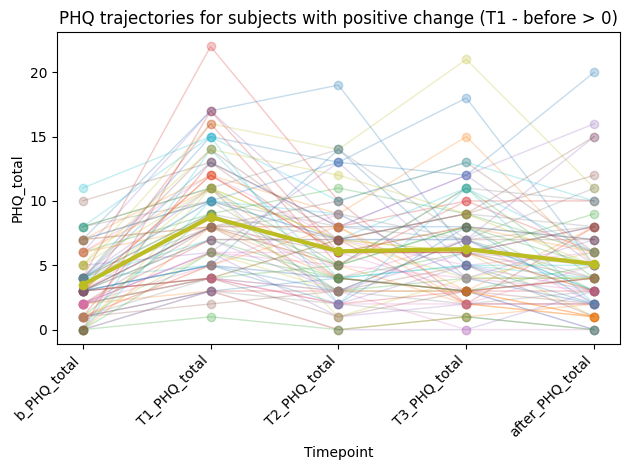

Positive-change subjects: 78
Saved filtered wide: only_Q_outputs\combined\positive_change_subjects.csv
Saved long trajectories: only_Q_outputs\combined\positive_change_trajectories_long.csv
Saved plot: only_Q_outputs\combined\positive_change_trajectories.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

input_path = r"only_Q_outputs\combined\phq_totals.csv"
out_filtered_path = r"only_Q_outputs\combined\positive_change_subjects.csv"
out_long_path = r"only_Q_outputs\combined\positive_change_trajectories_long.csv"
out_plot_path = r"only_Q_outputs\combined\positive_change_trajectories.png"

subject_col = "Subject_Code"
phq_before_col = "b_PHQ_total"
phq_t1_col = "T1_PHQ_total"

# EDIT this list to include ALL PHQ timepoints you want to examine, in order:
timepoint_cols = [
    "b_PHQ_total",
    "T1_PHQ_total",
    "T2_PHQ_total",
    "T3_PHQ_total",
    "after_PHQ_total"
    # add/remove based on your real columns
]

# 1) Load
df = pd.read_csv(input_path)

# 2) Numeric conversion for all timepoints we’ll use
for c in timepoint_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 3) Compute diff and filter positive change (T1 - before > 0)
df["diff_T1_minus_before"] = df[phq_t1_col] - df[phq_before_col]
pos = df[df["diff_T1_minus_before"] > 0].copy()

# Save the filtered wide table (optional)
pos.to_csv(out_filtered_path, index=False)

# 4) Keep only columns that actually exist
tp_cols_existing = [c for c in timepoint_cols if c in pos.columns]
if len(tp_cols_existing) < 2:
    raise ValueError("Not enough PHQ timepoint columns found. Check your timepoint_cols list.")

# 5) Reshape to long format for trajectory analysis
long = pos[[subject_col] + tp_cols_existing].melt(
    id_vars=[subject_col],
    value_vars=tp_cols_existing,
    var_name="timepoint",
    value_name="PHQ_total"
)

# Ensure timepoint order
long["timepoint"] = pd.Categorical(long["timepoint"], categories=tp_cols_existing, ordered=True)
long = long.sort_values([subject_col, "timepoint"])

# Save long data (optional)
long.to_csv(out_long_path, index=False)

# 6) Plot trajectories (spaghetti plot) + mean trajectory
plt.figure()
for sid, g in long.dropna(subset=["PHQ_total"]).groupby(subject_col):
    plt.plot(g["timepoint"], g["PHQ_total"], marker="o", linewidth=1, alpha=0.25)

mean_traj = long.groupby("timepoint", observed=True)["PHQ_total"].mean()
plt.plot(mean_traj.index.astype(str), mean_traj.values, marker="o", linewidth=3)

plt.title("PHQ trajectories for subjects with positive change (T1 - before > 0)")
plt.xlabel("Timepoint")
plt.ylabel("PHQ_total")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(f"Positive-change subjects: {pos[subject_col].nunique()}")
print(f"Saved filtered wide: {out_filtered_path}")
print(f"Saved long trajectories: {out_long_path}")
print(f"Saved plot: {out_plot_path}")


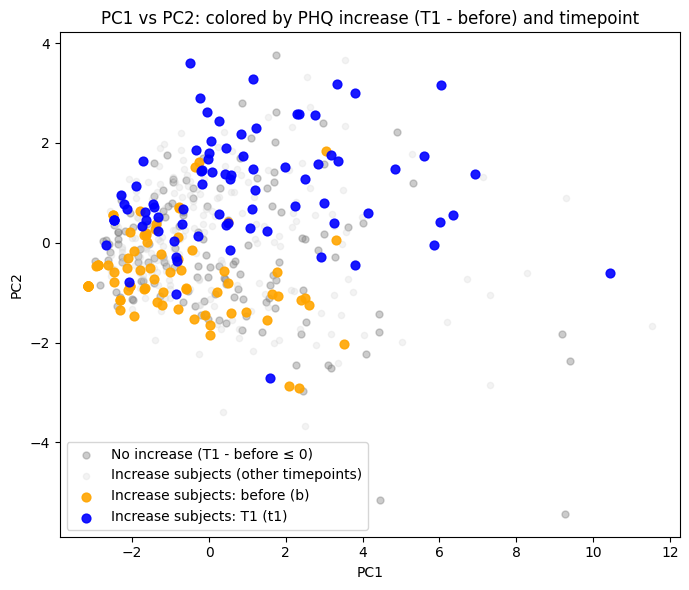

Saved figure: only_Q_outputs\combined\pca_pc1_pc2_phq_increase_timepoints.png
Counts: no increase rows = 155 increase b rows = 78 increase t1 rows = 78 increase other rows = 234 missing flag rows = 0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==== PATHS ====
pca_path = r"only_Q_outputs\combined\combined_pca_components.csv"
phq_path = r"only_Q_outputs\combined\phq_totals.csv"
out_fig = r"only_Q_outputs\combined\pca_pc1_pc2_phq_increase_timepoints.png"

# ==== COLUMNS ====
subject_col = "Subject_Code"
timepoint_col = "timepoint"     # in your PCA file: b, t1, t2, t3, after
pc1_col = "PC1"
pc2_col = "PC2"

phq_before_col = "b_PHQ_total"
phq_t1_col = "T1_PHQ_total"     # used to define "increase"
# ==================

# Load
pca = pd.read_csv(pca_path)
phq = pd.read_csv(phq_path)

# PHQ numeric + diff/flag
phq[phq_before_col] = pd.to_numeric(phq[phq_before_col], errors="coerce")
phq[phq_t1_col] = pd.to_numeric(phq[phq_t1_col], errors="coerce")

phq["diff_T1_minus_before"] = phq[phq_t1_col] - phq[phq_before_col]
phq["increase_flag"] = np.where(
    phq["diff_T1_minus_before"].isna(),
    np.nan,
    (phq["diff_T1_minus_before"] > 0).astype(int)
)

# Merge flag into PCA rows
df = pca.merge(phq[[subject_col, "increase_flag"]], on=subject_col, how="left")

# Clean
df = df.dropna(subset=[pc1_col, pc2_col])
df[timepoint_col] = df[timepoint_col].astype(str).str.lower()

# Masks
no_inc = df["increase_flag"] == 0
inc = df["increase_flag"] == 1

inc_b = inc & (df[timepoint_col] == "b")
inc_t1 = inc & (df[timepoint_col] == "t1")
inc_other = inc & (~df[timepoint_col].isin(["b", "t1"]))

# Plot
plt.figure(figsize=(7, 6))

# 1) No-increase subjects (gray)
plt.scatter(
    df.loc[no_inc, pc1_col], df.loc[no_inc, pc2_col],
    c="gray", alpha=0.4, s=25, label="No increase (T1 - before ≤ 0)"
)

# (optional) other timepoints for increase subjects (faint)
plt.scatter(
    df.loc[inc_other, pc1_col], df.loc[inc_other, pc2_col],
    c="lightgray", alpha=0.25, s=20, label="Increase subjects (other timepoints)"
)

# 2) Increase subjects: before pregnancy (b) — color A
plt.scatter(
    df.loc[inc_b, pc1_col], df.loc[inc_b, pc2_col],
    c="orange", alpha=0.9, s=40, label="Increase subjects: before (b)"
)

# 3) Increase subjects: first trimester (t1) — color B
plt.scatter(
    df.loc[inc_t1, pc1_col], df.loc[inc_t1, pc2_col],
    c="blue", alpha=0.9, s=40, label="Increase subjects: T1 (t1)"
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2: colored by PHQ increase (T1 - before) and timepoint")
plt.legend()
plt.tight_layout()
plt.savefig(out_fig, dpi=200)
plt.show()

print("Saved figure:", out_fig)
print("Counts:",
      "no increase rows =", int(no_inc.sum()),
      "increase b rows =", int(inc_b.sum()),
      "increase t1 rows =", int(inc_t1.sum()),
      "increase other rows =", int(inc_other.sum()),
      "missing flag rows =", int(df["increase_flag"].isna().sum()))


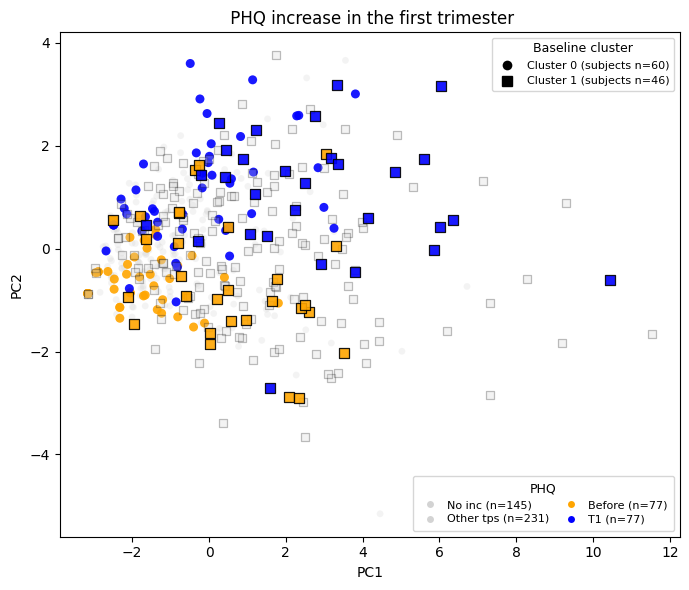

Saved figure: only_Q_outputs\combined\pca_pc1_pc2_phq_increase_timepoints_cluster_markers.png
Cluster column used: Cluster
Subjects per cluster: {0: 60, 1: 46}
Point counts: {'No increase': 145, 'Other timepoints': 231, 'Before (b)': 77, 'T1': 77}


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# ==== PATHS ====
pca_path = r"only_Q_outputs\combined\combined_pca_components.csv"
phq_path = r"only_Q_outputs\combined\phq_totals.csv"
cluster_path = r"only_Q_outputs\combined\subject_cluster_labels_k2.csv"
out_fig = r"only_Q_outputs\combined\pca_pc1_pc2_phq_increase_timepoints_cluster_markers.png"

# ==== COLUMNS ====
subject_col = "Subject_Code"
timepoint_col = "timepoint"
pc1_col = "PC1"
pc2_col = "PC2"

phq_before_col = "b_PHQ_total"
phq_t1_col = "T1_PHQ_total"
# ==================

# Load
pca = pd.read_csv(pca_path)
phq = pd.read_csv(phq_path)
clusters = pd.read_csv(cluster_path)

# ---- Find cluster column robustly ----
cluster_candidates = [
    c for c in clusters.columns
    if c.lower() != subject_col.lower() and ("cluster" in c.lower() or "group" in c.lower())
]
cluster_col = cluster_candidates[0] if len(cluster_candidates) else clusters.columns[1]

# PHQ numeric + diff/flag
phq[phq_before_col] = pd.to_numeric(phq[phq_before_col], errors="coerce")
phq[phq_t1_col] = pd.to_numeric(phq[phq_t1_col], errors="coerce")

phq["diff_T1_minus_before"] = phq[phq_t1_col] - phq[phq_before_col]
phq["increase_flag"] = np.where(
    phq["diff_T1_minus_before"].isna(),
    np.nan,
    (phq["diff_T1_minus_before"] > 0).astype(int)
)

# Merge flag + cluster into PCA rows
df = pca.merge(phq[[subject_col, "increase_flag"]], on=subject_col, how="left")
df = df.merge(clusters[[subject_col, cluster_col]], on=subject_col, how="left")

# Clean
df = df.dropna(subset=[pc1_col, pc2_col]).copy()
df[timepoint_col] = df[timepoint_col].astype(str).str.lower()
df[cluster_col] = pd.to_numeric(df[cluster_col], errors="coerce")

# Drop rows without cluster assignment
df = df.dropna(subset=[cluster_col]).copy()
df[cluster_col] = df[cluster_col].astype(int)

# Marker map: cluster 0 = dot, cluster 1 = square
marker_map = {0: "o", 1: "s"}

# Masks (PHQ increase definition is T1 - before)
no_inc = df["increase_flag"] == 0
inc = df["increase_flag"] == 1

inc_b = inc & (df[timepoint_col] == "b")
inc_t1 = inc & (df[timepoint_col] == "t1")
inc_other = inc & (~df[timepoint_col].isin(["b", "t1"]))

# --- counts for legends ---
subj_by_cluster = df.groupby(cluster_col)[subject_col].nunique().to_dict()

pt_counts = {
    "No increase": int(no_inc.sum()),
    "Other timepoints": int(inc_other.sum()),
    "Before (b)": int(inc_b.sum()),
    "T1": int(inc_t1.sum()),
}

# --- helper scatter: split by cluster; make cluster 1 pop ---
def scatter_by_cluster(mask, color, alpha, base_size):
    if mask.sum() == 0:
        return

    for cl in sorted(df.loc[mask, cluster_col].unique()):
        m = marker_map.get(cl, "o")
        msk = mask & (df[cluster_col] == cl)

        if cl == 1:
            s = base_size * 1.25
            edge = "black"
            lw = 0.9
            z = 5
        else:
            s = base_size
            edge = "none"
            lw = 0.0
            z = 3

        plt.scatter(
            df.loc[msk, pc1_col], df.loc[msk, pc2_col],
            c=color, alpha=alpha, s=s, marker=m,
            edgecolors=edge, linewidths=lw, zorder=z
        )

# ================== PLOT ==================
fig, ax = plt.subplots(figsize=(7, 6))

# Shared color for "no increase" and "other timepoints"
other_color = "lightgray"

scatter_by_cluster(no_inc,    color=other_color, alpha=0.25, base_size=24)
scatter_by_cluster(inc_other, color=other_color, alpha=0.25, base_size=24)
scatter_by_cluster(inc_b,     color="orange",    alpha=0.90, base_size=42)
scatter_by_cluster(inc_t1,    color="blue",      alpha=0.90, base_size=42)

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title(" PHQ increase in the first trimester")

# ---- Build legends ----
color_handles = [
    Line2D([0],[0], marker="o", linestyle="None", markersize=5,
           markerfacecolor=other_color, markeredgecolor="none",
           label=f"No inc (n={pt_counts['No increase']})"),
    Line2D([0],[0], marker="o", linestyle="None", markersize=5,
           markerfacecolor=other_color, markeredgecolor="none",
           label=f"Other tps (n={pt_counts['Other timepoints']})"),
    Line2D([0],[0], marker="o", linestyle="None", markersize=5,
           markerfacecolor="orange", markeredgecolor="none",
           label=f"Before (n={pt_counts['Before (b)']})"),
    Line2D([0],[0], marker="o", linestyle="None", markersize=5,
           markerfacecolor="blue", markeredgecolor="none",
           label=f"T1 (n={pt_counts['T1']})"),
]

cluster_handles = [
    Line2D([0], [0], marker="o", color="black", linestyle="None", markersize=7,
           markerfacecolor="black", markeredgecolor="none",
           label=f"Cluster 0 (subjects n={subj_by_cluster.get(0, 0)})"),
    Line2D([0], [0], marker="s", color="black", linestyle="None", markersize=7,
           markerfacecolor="black", markeredgecolor="black",
           label=f"Cluster 1 (subjects n={subj_by_cluster.get(1, 0)})"),
]

# === OPTION 1 (INSIDE): Cluster upper right, PHQ lower right ===
leg_cluster = ax.legend(
    handles=cluster_handles,
    loc="upper right",
    frameon=True,
    title="Baseline cluster",
    fontsize=8,
    title_fontsize=9
)
ax.add_artist(leg_cluster)

ax.legend(
    handles=color_handles,
    loc="lower right",
    frameon=True,
    title="PHQ",
    fontsize=8,
    title_fontsize=9,
    ncol=2,
    columnspacing=1.0,
    handletextpad=0.5,
    borderpad=0.6,
    labelspacing=0.4
)

fig.tight_layout()
plt.savefig(out_fig, dpi=200)
plt.show()

print("Saved figure:", out_fig)
print("Cluster column used:", cluster_col)
print("Subjects per cluster:", subj_by_cluster)
print("Point counts:", pt_counts)


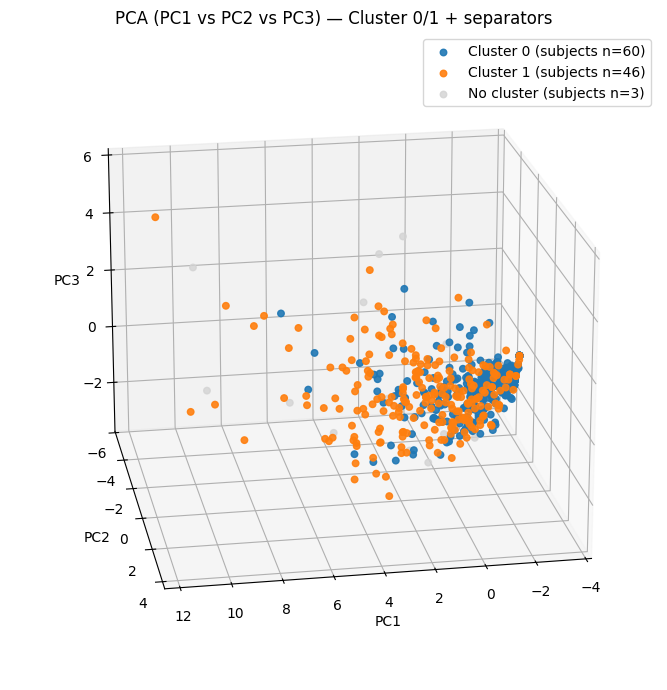

Saved figure: only_Q_outputs\combined\pca_pc1_pc2_pc3_by_cluster_3d.png
Cluster column used: Cluster
Row counts: cluster0 = 300 cluster1 = 230 no cluster = 15
Subject counts: cluster0 = 60 cluster1 = 46 no cluster = 3


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projection

# ==== PATHS ====
pca_path     = r"only_Q_outputs\combined\combined_pca_components.csv"
cluster_path = r"only_Q_outputs\combined\subject_cluster_labels_k2.csv"
out_fig      = r"only_Q_outputs\combined\pca_pc1_pc2_pc3_by_cluster_3d.png"

# ==== COLUMNS ====
subject_col = "Subject_Code"
pc1_col = "PC1"
pc2_col = "PC2"
pc3_col = "PC3"   # <-- make sure this exists in your PCA file

# Load
pca = pd.read_csv(pca_path)
clusters = pd.read_csv(cluster_path)

# --- find cluster column robustly ---
cluster_candidates = [
    c for c in clusters.columns
    if c.lower() != subject_col.lower()
    and ("cluster" in c.lower() or "group" in c.lower() or "label" in c.lower())
]
cluster_col = cluster_candidates[0] if cluster_candidates else clusters.columns[1]

# Merge cluster into PCA rows
df = pca.merge(clusters[[subject_col, cluster_col]], on=subject_col, how="left")

# Clean numeric PCA
for col in [pc1_col, pc2_col, pc3_col]:
    df[col] = pd.to_numeric(df[col], errors="coerce")
df = df.dropna(subset=[pc1_col, pc2_col, pc3_col]).copy()

# Clean cluster
df[cluster_col] = pd.to_numeric(df[cluster_col], errors="coerce")

# OPTIONAL: if clusters are labeled as 1/2 instead of 0/1, remap to 0/1
uniq = sorted([u for u in df[cluster_col].dropna().unique()])
if uniq == [1, 2]:
    df[cluster_col] = df[cluster_col].map({1: 0, 2: 1})

# Masks
c0 = df[cluster_col] == 0
c1 = df[cluster_col] == 1
no_cluster = df[cluster_col].isna()

# Subject counts
n_subj_c0 = df.loc[c0, subject_col].nunique()
n_subj_c1 = df.loc[c1, subject_col].nunique()
n_subj_nc = df.loc[no_cluster, subject_col].nunique()

# ===== 3D Plot =====
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(df.loc[c0, pc1_col], df.loc[c0, pc2_col], df.loc[c0, pc3_col],
           c="tab:blue", s=22, alpha=0.9, label=f"Cluster 0 (subjects n={n_subj_c0})")

ax.scatter(df.loc[c1, pc1_col], df.loc[c1, pc2_col], df.loc[c1, pc3_col],
           c="tab:orange", s=22, alpha=0.9, label=f"Cluster 1 (subjects n={n_subj_c1})")

if no_cluster.any():
    ax.scatter(df.loc[no_cluster, pc1_col], df.loc[no_cluster, pc2_col], df.loc[no_cluster, pc3_col],
               c="lightgray", s=22, alpha=0.8, label=f"No cluster (subjects n={n_subj_nc})")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA (PC1 vs PC2 vs PC3) — Cluster 0/1 + separators")

# Optional: choose a nicer default view angle

ax.view_init(elev=20, azim=80)

# ---------- AUTO-FIND BEST VIEW (based on cluster separation) ----------
df2 = df.loc[~df[cluster_col].isna()].copy()          # only rows with a cluster
df2[cluster_col] = df2[cluster_col].astype(int)
df2 = df2[df2[cluster_col].isin([0, 1])].copy()       # only 0/1 clusters

X = df2[[pc1_col, pc2_col, pc3_col]].values
y = df2[cluster_col].values

# Then set:
ax.view_init(elev=20, azim=80)


ax.legend(loc="upper right")
plt.tight_layout()
plt.savefig(out_fig, dpi=200)
plt.show()

print("Saved figure:", out_fig)
print("Cluster column used:", cluster_col)
print("Row counts:",
      "cluster0 =", int(c0.sum()),
      "cluster1 =", int(c1.sum()),
      "no cluster =", int(no_cluster.sum()))
print("Subject counts:",
      "cluster0 =", int(n_subj_c0),
      "cluster1 =", int(n_subj_c1),
      "no cluster =", int(n_subj_nc))
